# Autofocus


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import aps.ai.autoalignment.beamline28IDB.optimization.configs as configs
import aps.ai.autoalignment.beamline28IDB.optimization.movers as movers
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline28IDB.simulation.facade.focusing_optics_interface import (
    Layout,
    get_default_input_features,
)
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import get_distribution_info, load_beam, plot_distribution
from datetime import datetime
import joblib

%matplotlib inline

28-ID - VKB Pitch Motor Resolution: 2e-05 deg
Qt5Agg: unable to import specified backend (or its dependency); no plots


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.
Traceback (most recent call last):
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot.py", line 57, in uti_plot_init
    _backend = uti_plot_matplotlib.Backend(backend, fname_format)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 27, in __init__
    backend = self._init_ipython(backend)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 724, in _init_ipython
    get_ipython().magic('matplotlib ' + b)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.

In [3]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)

In [4]:
class OptimizationParameters:
    def __init__(self):
        self.move_motors_ranges = configs.DEFAULT_MOVEMENT_RANGES

        self.params = {
            "sum_intensity_soft_constraint": 7e3,
            "sum_intensity_hard_constraint": 6.5e3,
            "reference_parameters_h_v": {"peak": (0.0, 0.0), "fwhm": (0.00, 0.0)},
            #            "centroid_sigma_loss_threshold_dependency": CentroidSigmaLossThresholdDependency.FULLY_DYNAMIC,
            #            "centroid_sigma_loss_hard_thresholds": [0.01, 0.03],
            "loss_parameters": ["peak", "fwhm"],
            "multi_objective_optimization": True,
            "n_pitch_trans_motor_trials": 50,
            "n_all_motor_trials": 100,
        }

In [25]:
class SimulationParameters:
    def __init__(self):
        detector_x = 2160 * 0.65 * 1e-3
        detector_y = 2560 * 0.65 * 1e-3

        xrange = [-detector_x / 2, detector_x / 2]
        yrange = [-detector_y / 2, detector_y / 2]

        self.params = {
            "xrange": xrange,
            "yrange": yrange,
            "nbins_h": 2048,
            "nbins_v": 2048,
            "do_gaussian_fit": False,
            "implementor": Implementors.SHADOW,
            "random_seed": DEFAULT_RANDOM_SEED,
        }

In [26]:

def setup_work_dir():
    root_dir = Path(aps.__path__[0]).parents[0]
    work_dir = root_dir / "work_directory/28-ID"
    os.chdir(work_dir)

In [27]:
def print_beam_attributes(loss_parameters, hist, dw, title):
    loss_dw_functions = {
        "peak": opt_common._get_peak_distance_from_dw,
        "centroid": opt_common._get_centroid_distance_from_dw,
        "sigma": opt_common._get_sigma_from_dw,
        "fwhm": opt_common._get_fwhm_from_dw,
    }
    loss_hist_functions = {
        "weighted_sum_intensity": lambda hist: opt_common._get_weighted_sum_intensity_from_hist(hist, 2)
    }

    attribs = {}
    for ltype, lfn in loss_dw_functions.items():
        if ltype in loss_parameters:
            loss = lfn(dw)
            attribs[ltype] = loss
            print(f"{title} system {ltype}: {loss:4.3e}")
    for ltype, lfn in loss_hist_functions.items():
        if ltype in loss_parameters:
            loss = lfn(hist)
            attribs[ltype] = loss
            print(f"{title} system {ltype}: {loss:4.3e}")
    return attribs

In [28]:
plot_mode = PlotMode.INTERNAL
aspect_ratio = AspectRatio.AUTO
color_map = ColorMap.VIRIDIS

In [41]:
setup_work_dir()
clean_up()

sim_params = SimulationParameters()
print("Simulation parameters")
print(sim_params.__dict__)

Simulation parameters
{'params': {'xrange': [-0.7020000000000001, 0.7020000000000001], 'yrange': [-0.8320000000000001, 0.8320000000000001], 'nbins_h': 2048, 'nbins_v': 2048, 'do_gaussian_fit': False, 'implementor': 0, 'random_seed': 39999}}


In [42]:
opt_params = OptimizationParameters()

print("Motors and movement ranges")
print(opt_params.move_motors_ranges)

print("Optimization parameters")
print(opt_params.params)

Motors and movement ranges
{'hb_1': [-25, 25], 'hb_2': [-25, 25], 'hb_pitch': [-0.002, 0.002], 'hb_trans': [-0.03, 0.03], 'vb_bender': [-20.0, 20.0], 'vb_pitch': [-0.002, 0.002], 'vb_trans': [-0.03, 0.03]}
Optimization parameters
{'sum_intensity_soft_constraint': 7000.0, 'sum_intensity_hard_constraint': 6500.0, 'reference_parameters_h_v': {'peak': (0.0, 0.0), 'fwhm': (0.0, 0.0)}, 'loss_parameters': ['peak', 'fwhm'], 'multi_objective_optimization': True, 'n_pitch_trans_motor_trials': 50, 'n_all_motor_trials': 100}


In [277]:
input_beam_path = "primary_optics_system_beam.dat"

clean_up()

# Initializing the focused beam from simulation
input_features = get_default_input_features(layout=Layout.AUTO_FOCUSING)
input_beam = load_shadow_beam(input_beam_path)
focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=True,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    layout=Layout.AUTO_FOCUSING,
    input_features=input_features,
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


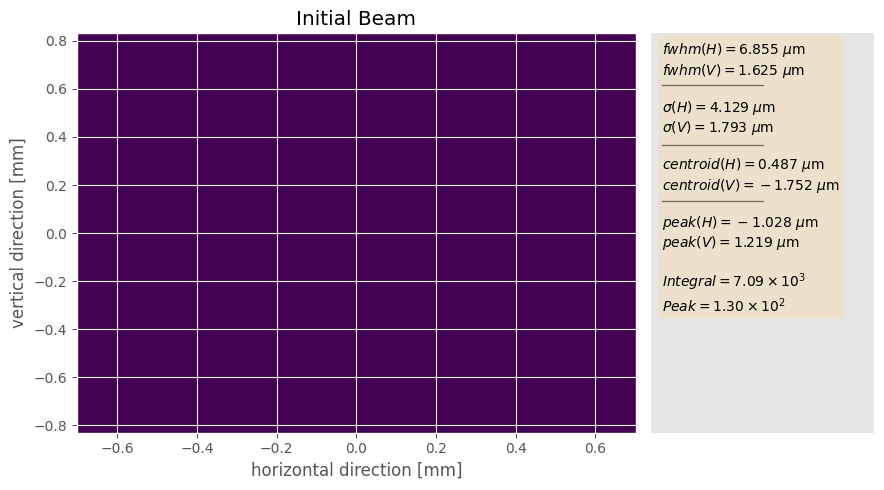

In [278]:
beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system=focusing_system, photon_beam=None, **sim_params.params)
plot_distribution(
    beam=beam,
    title="Initial Beam",
    plot_mode=plot_mode,
    aspect_ratio=aspect_ratio,
    color_map=color_map,
    **sim_params.params,
)

In [279]:
attribs_focus = print_beam_attributes(["peak", "fwhm", "weighted_sum_intensity"], hist, dw, "Focused beam")

Focused beam system peak: 1.106e-03
Focused beam system fwhm: 7.045e-03
Focused beam system weighted_sum_intensity: 7.621e-02


In [280]:
np.log(7.621e-2)

-2.574262591304111

In [96]:
mots = list(opt_params.move_motors_ranges.keys())
initial_absolute_positions = {k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}
print("Focused absolute position are", initial_absolute_positions)



Focused absolute position are {'hb_1': -168.0, 'hb_2': -161.0, 'hb_pitch': 0.17188733853924987, 'hb_trans': 0.0, 'vb_bender': 419.0, 'vb_pitch': 0.17188733853924987, 'vb_trans': 0.0}


In [97]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system,
    motor_types_and_ranges=opt_params.move_motors_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    **sim_params.params,
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is (ABSOLUTE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-181.7, -160.8, 0.17048733853924986, 0.0482, 423.5, 0.16996733853924986, -0.0228]
Random initialization is (RELATIVE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-13.652067633677945, 0.20197839019894914, -0.0013803254516584315

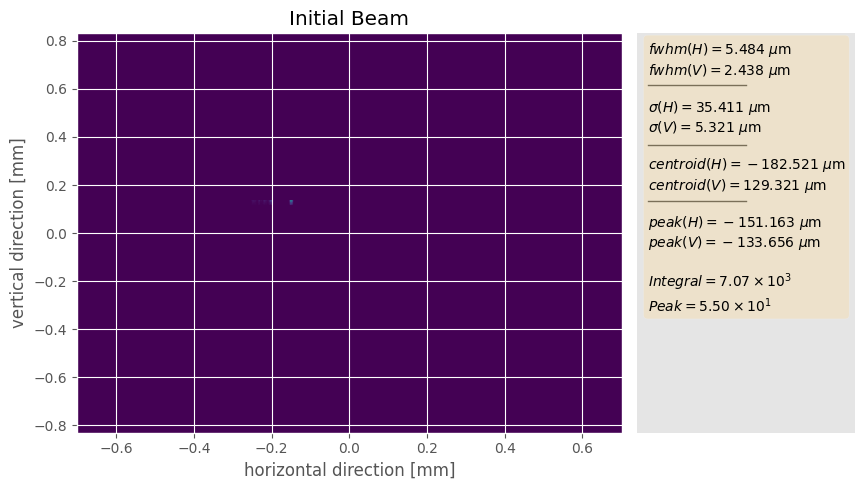

Perturbed beam system peak: 2.023e-01
Perturbed beam system fwhm: 6.002e-03


In [98]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(focusing_system=focusing_system, photon_beam=None, **sim_params.params)
plot_distribution(
    beam=beam_pert,
    title="Initial Beam",
    plot_mode=plot_mode,
    aspect_ratio=aspect_ratio,
    color_map=color_map,
    **sim_params.params,
)
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

In [99]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

#### WITHOUT MOO THRESHOLDS

In [181]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


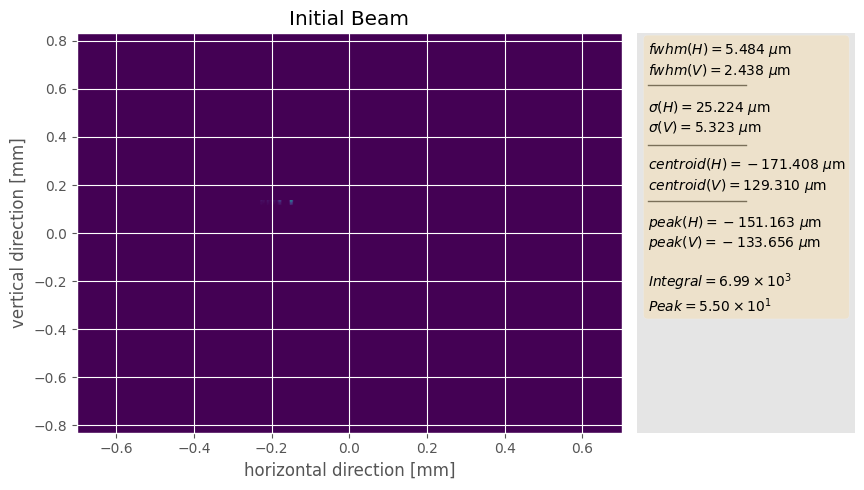

In [182]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(focusing_system=focusing_system, photon_beam=None, **sim_params.params)
plot_distribution(
    beam=beam_pert,
    title="Initial Beam",
    plot_mode=plot_mode,
    aspect_ratio=aspect_ratio,
    color_map=color_map,
    **sim_params.params,
)

In [183]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system peak: 2.023e-01
Perturbed beam system fwhm: 6.002e-03


In [184]:
# Now the optimization
opt_trial = OptunaOptimizer(
    focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    reference_parameters_h_v=opt_params.params["reference_parameters_h_v"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    **sim_params.params,
    )

In [185]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    #moo_thresholds={"peak": 0.02, "fwhm": 0.02},
)

[I 2022-11-18 01:48:57,887] A new study created in memory with name: no-name-69d74797-edcc-4216-a23a-fea602c9acfc


In [186]:
n1 = 25#opt_params.params["n_pitch_trans_motor_trials"]
print(f"First optimizing only the pitch and translation motors for {n1} trials.")

opt_trial.trials(n1, trial_motor_types=["hb_pitch", "hb_trans", "vb_pitch", "vb_trans"])

/Users/skandel/code/oasys/AI-ML_Control_System/aps/ai/autoalignment/beamline28IDB/optimization/optuna_botorch.py:341: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2022-11-18 0

First optimizing only the pitch and translation motors for 25 trials.


[I 2022-11-18 01:49:00,050] Trial 1 finished with values: [0.18570864592912378, 0.006825120906667449] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': 0.014200000000000004, 'vb_bender': 0.0, 'vb_pitch': -0.00074, 'vb_trans': -0.017099999999999997}. 
[I 2022-11-18 01:49:00,205] Trial 2 finished with values: [0.2520288583962474, 0.005382393298830218] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.015499999999999998, 'vb_bender': 0.0, 'vb_pitch': -0.0002999999999999999, 'vb_trans': 0.0022000000000000006}. 
[I 2022-11-18 01:49:00,361] Trial 3 finished with values: [0.29748100761408347, 0.006001647722969616] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': -0.029599999999999998, 'vb_bender': 0.0, 'vb_pitch': -0.00152, 'vb_trans': 0.019300000000000005}. 
[I 2022-11-18 01:49:00,516] Trial 4 finished with values: [0.2906248895082982, 0.006001647722969616] and parame

Pruning trial with parameters [0.0, 0.0, 0.0019, -0.0236, 0.0, 2.0000000000000052e-05, -0.0269]


[I 2022-11-18 01:49:00,973] Trial 7 finished with values: [0.14856240689696398, 0.00638032608442578] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': -0.0298, 'vb_bender': 0.0, 'vb_pitch': 0.0012600000000000003, 'vb_trans': 0.016600000000000004}. 
[I 2022-11-18 01:49:01,133] Trial 8 finished with values: [0.19522977912564424, 0.0062231898728548765] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.0257, 'vb_bender': 0.0, 'vb_pitch': 0.0015600000000000002, 'vb_trans': 0.0262}. 
[I 2022-11-18 01:49:01,287] Trial 9 finished with values: [0.38149025828996364, 0.008845271650232604] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.012899999999999998, 'vb_bender': 0.0, 'vb_pitch': -0.00188, 'vb_trans': 0.0299}. 
[I 2022-11-18 01:49:01,441] Trial 10 finished with values: [0.2754576191938825, 0.006825120906667449] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitc

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_40708/1961813434.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


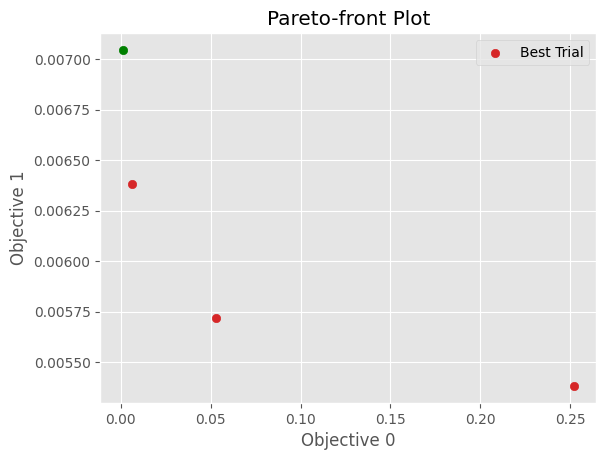

In [187]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(*attribs_focus.values(), color='green')

In [188]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

-6.602833833223579 285.32892211302146
-8.1067354233941 0.2491659893343757
-10.153448162044072 1.169815479126928


[0.2520288583962474, 0.005382393298830218]


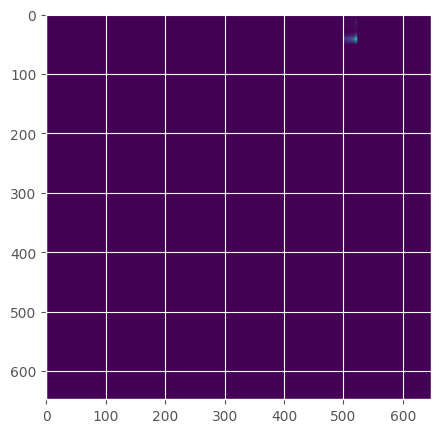

[0.05270958142015407, 0.00572005193513359]


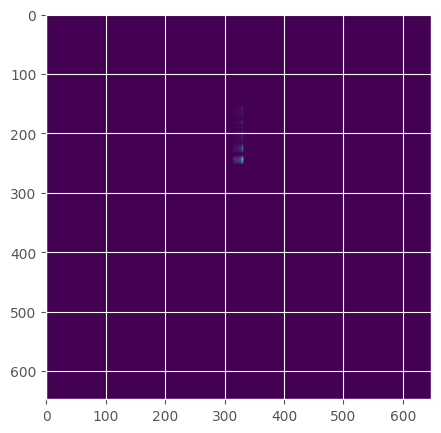

[0.006103382889181622, 0.00638032608442578]


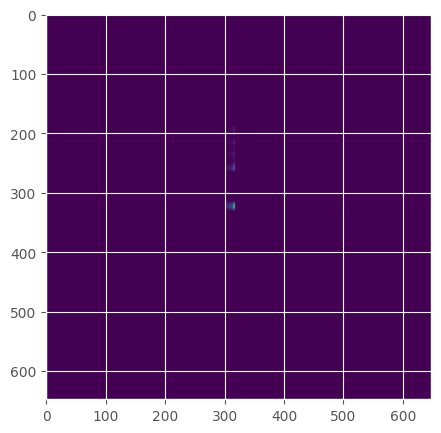

In [189]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    # for mot in opt_trial.motor_types:
    #    current_params.append(params[mot])
    # opt_trial._loss_fn_this(current_params)
    # print(t.values)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    print(vals)
    plt.figure(figsize=[5, 5])
    plt.imshow(t.user_attrs["data_2D"][700:-700,700:-700])
    #plt.axis("off")
    plt.show()

In [190]:
n2 = 50#opt_params.params["n_all_motor_trials"]
print(f"Optimizing all motors together for {n2} trials.")
opt_trial.trials(n2)

Optimizing all motors together for 50 trials.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:49:44,831] Trial 25 finished with values: [0.084098304588338, 0.07807795539121465] and parameters: {'hb_1': -6.0, 'hb_2': 5.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': 0.0274, 'vb_bender': 7.0, 'vb_pitch': 0.00198, 'vb_trans': 0.015700000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:50:04,224] Trial 26 finished with values: [0.01258535831570288, 0.0055442335259822] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0015, 'hb_trans': 0.004800000000000006, 'vb_bender': -1.0, 'vb_pitch': 0.00198, 'vb_trans': 0.0189}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:50:25,319] Trial 27 finished with values: [0.005430166714604674, 0.034315840650575045] and parameters: {'hb_1': 5.0, 'hb_2': -3.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.0010000000000000009, 'vb_bender': -1.0, 'vb_pitch': 0.0019399999999999999, 'vb_trans': 0.019500000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:50:47,828] Trial 28 finished with values: [0.03490733791968007, 0.060350006553567224] and parameters: {'hb_1': 1.0, 'hb_2': -2.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': 0.015400000000000004, 'vb_bender': 2.0, 'vb_pitch': 0.00198, 'vb_trans': 0.0194}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:50:51,202] Trial 29 finished with values: [0.01274104117751644, 0.0062231898728548765] and parameters: {'hb_1': -1.0, 'hb_2': 1.0, 'hb_pitch': 0.0013, 'hb_trans': 0.0021000000000000046, 'vb_bender': -1.0, 'vb_pitch': 0.0018800000000000002, 'vb_trans': 0.019800000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be repl

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:50:57,950] Trial 30 finished with values: [0.0044818768604185525, 0.0055442335259822] and parameters: {'hb_1': 0.0, 'hb_2': -1.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.0021000000000000046, 'vb_bender': 0.0, 'vb_pitch': 0.00198, 'vb_trans': 0.021800000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/Applications/Oasys1.3.app/Co

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:51:13,385] Trial 31 finished with values: [0.008384915133497704, 0.03634306779583608] and parameters: {'hb_1': 0.0, 'hb_2': -3.0, 'hb_pitch': 0.0013, 'hb_trans': 0.0008000000000000021, 'vb_bender': 0.0, 'vb_pitch': 0.0018400000000000005, 'vb_trans': 0.0204}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:51:17,606] Trial 32 finished with values: [0.012249292508928757, 0.006903448995409939] and parameters: {'hb_1': -2.0, 'hb_2': 0.0, 'hb_pitch': 0.0013, 'hb_trans': -0.0011999999999999962, 'vb_bender': 0.0, 'vb_pitch': 0.0018400000000000005, 'vb_trans': 0.021300000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:51:21,003] Trial 33 finished with values: [0.013455983247075167, 0.028119162873549857] and parameters: {'hb_1': 3.0, 'hb_2': 0.0, 'hb_pitch': 0.0013, 'hb_trans': -0.0009999999999999974, 'vb_bender': 0.0, 'vb_pitch': 0.0018400000000000005, 'vb_trans': 0.021000000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, afte

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:51:43,797] Trial 34 finished with values: [0.019877247449373695, 0.06517255119753965] and parameters: {'hb_1': -2.0, 'hb_2': 4.0, 'hb_pitch': 0.0013, 'hb_trans': 0.019200000000000002, 'vb_bender': -3.0, 'vb_pitch': 0.00198, 'vb_trans': 0.024400000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:51:51,039] Trial 35 finished with values: [0.011866043126050836, 0.00572005193513359] and parameters: {'hb_1': -1.0, 'hb_2': -1.0, 'hb_pitch': 0.0013, 'hb_trans': -9.999999999999593e-05, 'vb_bender': -2.0, 'vb_pitch': 0.00198, 'vb_trans': 0.021900000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.0

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:53:24,723] Trial 44 finished with values: [0.019231957067484526, 0.006633953737674453] and parameters: {'hb_1': -1.0, 'hb_2': 1.0, 'hb_pitch': 0.0013, 'hb_trans': 0.0017000000000000001, 'vb_bender': -5.0, 'vb_pitch': 0.00168, 'vb_trans': 0.019100000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:53:29,021] Trial 45 finished with values: [0.006103382889181622, 0.006001647722969616] and parameters: {'hb_1': -1.0, 'hb_2': -1.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.005500000000000005, 'vb_bender': -3.0, 'vb_pitch': 0.0018400000000000005, 'vb_trans': 0.023000000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2022-11-18 01:53:32,310] Trial 46 

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:53:35,441] Trial 47 finished with values: [0.013515357183548253, 0.006001647722969616] and parameters: {'hb_1': -1.0, 'hb_2': 1.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.0017000000000000001, 'vb_bender': -4.0, 'vb_pitch': 0.0017000000000000001, 'vb_trans': 0.0189}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2022-11-18 01:53:41,123] Trial 48 finished with 

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:53:45,572] Trial 49 finished with values: [0.01152740666712589, 0.00572005193513359] and parameters: {'hb_1': -1.0, 'hb_2': -1.0, 'hb_pitch': 0.0013, 'hb_trans': 0.0020000000000000018, 'vb_bender': -3.0, 'vb_pitch': 0.0018400000000000005, 'vb_trans': 0.020800000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2022-11-18 01:53:48,676] Trial 50 finished with va

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:54:14,691] Trial 56 finished with values: [0.011866043126050836, 0.024799765751870612] and parameters: {'hb_1': -1.0, 'hb_2': 1.0, 'hb_pitch': 0.0015, 'hb_trans': -0.001799999999999996, 'vb_bender': -4.0, 'vb_pitch': 0.0018200000000000004, 'vb_trans': 0.020500000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, aft

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:55:24,082] Trial 59 finished with values: [0.0069147510939986554, 0.00638032608442578] and parameters: {'hb_1': -2.0, 'hb_2': 0.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.008300000000000002, 'vb_bender': -7.0, 'vb_pitch': 0.00198, 'vb_trans': 0.0204}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:55:49,390] Trial 60 finished with values: [0.012003946648730496, 0.007045429495937562] and parameters: {'hb_1': -1.0, 'hb_2': 0.0, 'hb_pitch': 0.0013, 'hb_trans': -0.008599999999999997, 'vb_bender': 1.0, 'vb_pitch': 0.0019000000000000002, 'vb_trans': 0.018600000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, afte

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:56:16,056] Trial 61 finished with values: [0.010999922361966862, 0.0055442335259822] and parameters: {'hb_1': 0.0, 'hb_2': -1.0, 'hb_pitch': 0.0013, 'hb_trans': -0.009099999999999997, 'vb_bender': 0.0, 'vb_pitch': 0.0019200000000000007, 'vb_trans': 0.018800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/Applications/Oasys1.3.app/Cont

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:56:37,974] Trial 62 finished with values: [0.010695640675962273, 0.006903448995409939] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0013, 'hb_trans': -0.0081, 'vb_bender': 0.0, 'vb_pitch': 0.00186, 'vb_trans': 0.017900000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:58:34,941] Trial 66 finished with values: [0.024485914287856826, 0.006633953737674453] and parameters: {'hb_1': -1.0, 'hb_2': 0.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': -0.008499999999999997, 'vb_bender': -3.0, 'vb_pitch': 0.0019399999999999999, 'vb_trans': 0.014400000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:59:13,351] Trial 67 finished with values: [0.044753857675429276, 0.00638032608442578] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.001, 'hb_trans': -0.008299999999999998, 'vb_bender': -1.0, 'vb_pitch': 0.0019000000000000002, 'vb_trans': 0.013500000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after 

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 01:59:40,601] Trial 68 finished with values: [0.012329501617890643, 0.006001647722969616] and parameters: {'hb_1': -1.0, 'hb_2': 0.0, 'hb_pitch': 0.0013, 'hb_trans': -0.0133, 'vb_bender': -3.0, 'vb_pitch': 0.0018400000000000005, 'vb_trans': 0.013500000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating 

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:00:09,185] Trial 69 finished with values: [0.01216781297709527, 0.00572005193513359] and parameters: {'hb_1': 1.0, 'hb_2': 0.0, 'hb_pitch': 0.0013, 'hb_trans': -0.014099999999999998, 'vb_bender': -2.0, 'vb_pitch': 0.0017600000000000003, 'vb_trans': 0.011600000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:00:43,542] Trial 70 finished with values: [0.01520197278446491, 0.00638032608442578] and parameters: {'hb_1': 0.0, 'hb_2': -1.0, 'hb_pitch': 0.0013, 'hb_trans': -0.013499999999999998, 'vb_bender': -2.0, 'vb_pitch': 0.0016400000000000004, 'vb_trans': 0.009500000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:01:17,491] Trial 71 finished with values: [0.013738281562377776, 0.00572005193513359] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0013, 'hb_trans': -0.012899999999999998, 'vb_bender': -1.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': -0.009899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:01:28,257] Trial 72 finished with values: [0.0005315380437518685, 0.00572005193513359] and parameters: {'hb_1': -1.0, 'hb_2': -1.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.004700000000000003, 'vb_bender': -2.0, 'vb_pitch': 0.00198, 'vb_trans': 0.028200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, af

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:01:53,728] Trial 73 finished with values: [0.001105658956279055, 0.00638032608442578] and parameters: {'hb_1': -1.0, 'hb_2': 0.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.004800000000000006, 'vb_bender': -2.0, 'vb_pitch': 0.00198, 'vb_trans': 0.027200000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-package

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_40708/1961813434.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


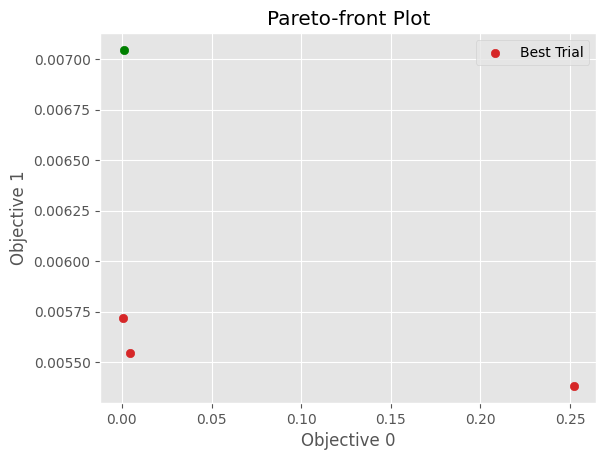

In [191]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(*attribs_focus.values(), color='green')

In [192]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

-6.602833833223579 285.32892211302146
-10.602710273919744 0.8590794910168779
-12.703513178722282 0.08765308056115799


[0.2520288583962474, 0.005382393298830218]


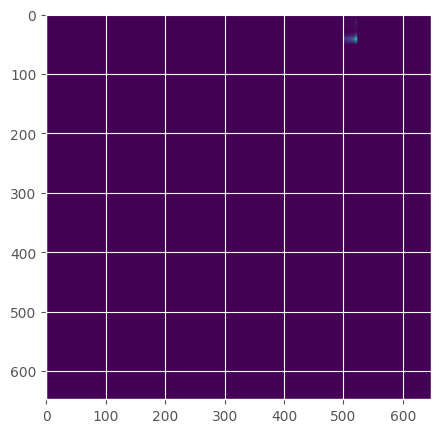

[0.0044818768604185525, 0.0055442335259822]


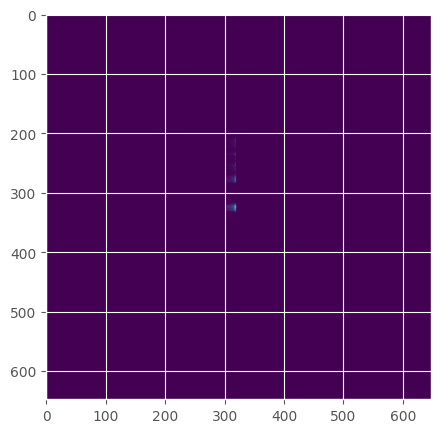

[0.0005315380437518685, 0.00572005193513359]


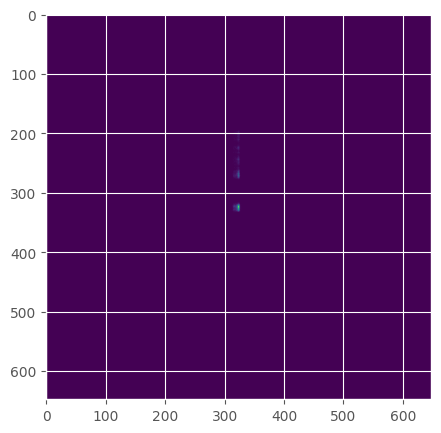

In [193]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    # for mot in opt_trial.motor_types:
    #    current_params.append(params[mot])
    # opt_trial._loss_fn_this(current_params)
    # print(t.values)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    print(vals)
    plt.figure(figsize=[5, 5])
    plt.imshow(t.user_attrs["data_2D"][700:-700,700:-700])
    #plt.axis("off")
    plt.show()

#### WITH MOO THRESHOLDS

In [194]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


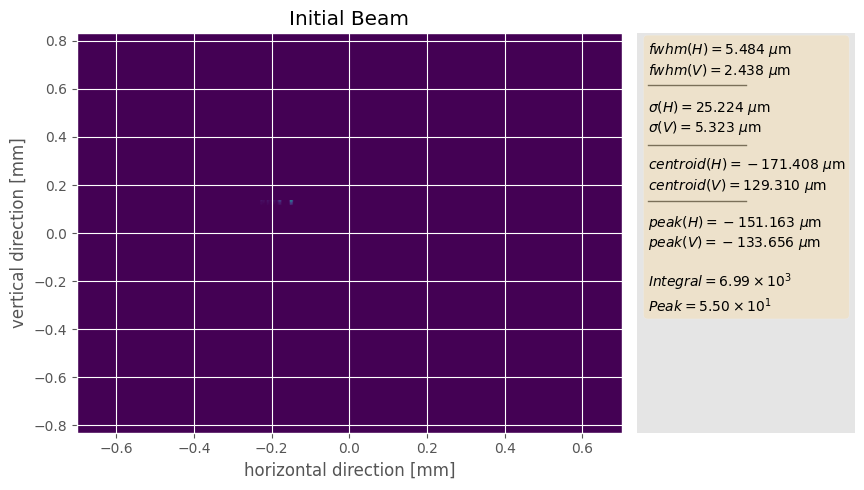

In [195]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(focusing_system=focusing_system, photon_beam=None, **sim_params.params)
plot_distribution(
    beam=beam_pert,
    title="Initial Beam",
    plot_mode=plot_mode,
    aspect_ratio=aspect_ratio,
    color_map=color_map,
    **sim_params.params,
)

In [196]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system peak: 2.023e-01
Perturbed beam system fwhm: 6.002e-03


In [197]:
# Now the optimization
opt_trial = OptunaOptimizer(
    focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    reference_parameters_h_v=opt_params.params["reference_parameters_h_v"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    **sim_params.params,
    )

In [198]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds={"peak": 0.02, "fwhm": 0.02},
)

[I 2022-11-18 02:02:24,741] A new study created in memory with name: no-name-9fbe5ba5-aada-40ed-9842-62a657ceb65e


In [199]:
n1 = 25#opt_params.params["n_pitch_trans_motor_trials"]
print(f"First optimizing only the pitch and translation motors for {n1} trials.")

opt_trial.trials(n1, trial_motor_types=["hb_pitch", "hb_trans", "vb_pitch", "vb_trans"])

/Users/skandel/code/oasys/AI-ML_Control_System/aps/ai/autoalignment/beamline28IDB/optimization/optuna_botorch.py:341: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2022-11-18 0

First optimizing only the pitch and translation motors for 25 trials.


[I 2022-11-18 02:02:25,112] Trial 1 finished with values: [0.18570864592912378, 0.006825120906667449] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': 0.014200000000000004, 'vb_bender': 0.0, 'vb_pitch': -0.00074, 'vb_trans': -0.017099999999999997}. 
[I 2022-11-18 02:02:25,277] Trial 2 finished with values: [0.2520288583962474, 0.005382393298830218] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.015499999999999998, 'vb_bender': 0.0, 'vb_pitch': -0.0002999999999999999, 'vb_trans': 0.0022000000000000006}. 
[I 2022-11-18 02:02:25,440] Trial 3 finished with values: [0.29748100761408347, 0.006001647722969616] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': -0.029599999999999998, 'vb_bender': 0.0, 'vb_pitch': -0.00152, 'vb_trans': 0.019300000000000005}. 
[I 2022-11-18 02:02:25,601] Trial 4 finished with values: [0.2906248895082982, 0.006001647722969616] and parame

Pruning trial with parameters [0.0, 0.0, 0.0019, -0.0236, 0.0, 2.0000000000000052e-05, -0.0269]


[I 2022-11-18 02:02:26,071] Trial 7 finished with values: [0.14856240689696398, 0.00638032608442578] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': -0.0298, 'vb_bender': 0.0, 'vb_pitch': 0.0012600000000000003, 'vb_trans': 0.016600000000000004}. 
[I 2022-11-18 02:02:26,232] Trial 8 finished with values: [0.19522977912564424, 0.0062231898728548765] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.0257, 'vb_bender': 0.0, 'vb_pitch': 0.0015600000000000002, 'vb_trans': 0.0262}. 
[I 2022-11-18 02:02:26,394] Trial 9 finished with values: [0.38149025828996364, 0.008845271650232604] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.012899999999999998, 'vb_bender': 0.0, 'vb_pitch': -0.00188, 'vb_trans': 0.0299}. 
[I 2022-11-18 02:02:26,553] Trial 10 finished with values: [0.2754576191938825, 0.006825120906667449] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitc

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_40708/1961813434.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


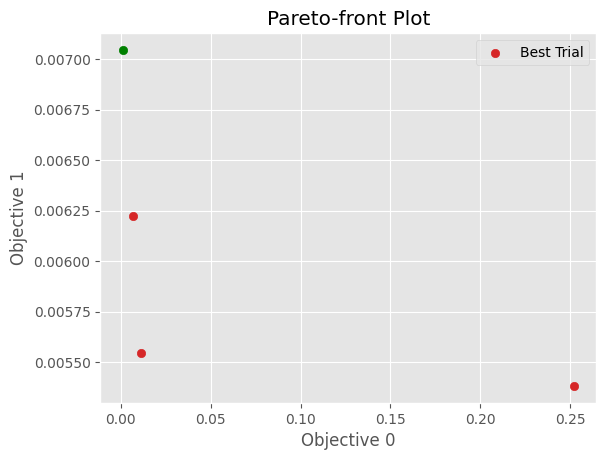

In [200]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(*attribs_focus.values(), color='green')

In [201]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

-6.602833833223579 285.32892210359455
-10.043837069990019 1.431502907924749
-9.683503156383056 0.6452679602173541


[0.2520288583962474, 0.005382393298830218]


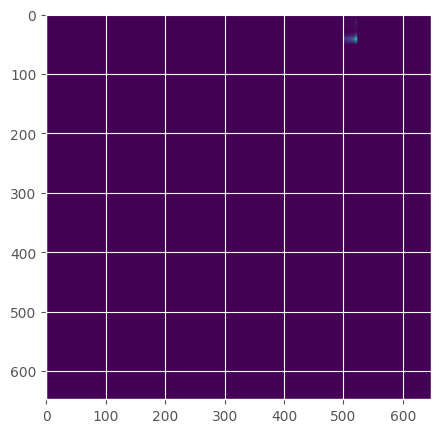

[0.0069823872513346125, 0.0062231898728548765]


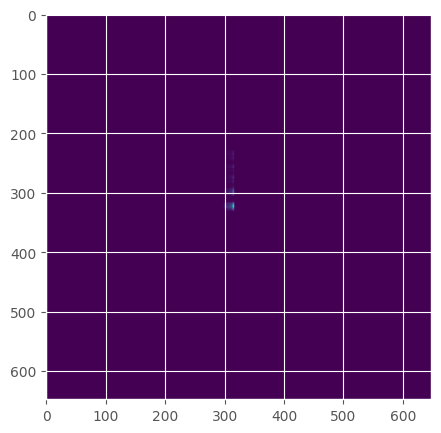

[0.011237417050608139, 0.0055442335259822]


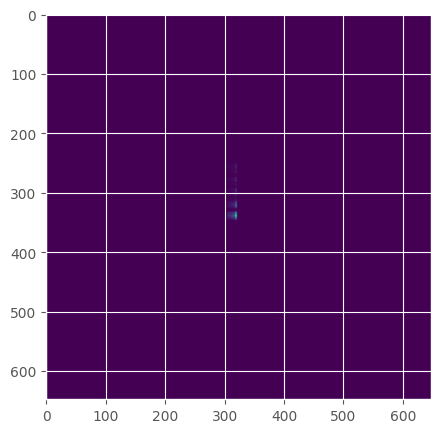

In [202]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    # for mot in opt_trial.motor_types:
    #    current_params.append(params[mot])
    # opt_trial._loss_fn_this(current_params)
    # print(t.values)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    print(vals)
    plt.figure(figsize=[5, 5])
    plt.imshow(t.user_attrs["data_2D"][700:-700,700:-700])
    #plt.axis("off")
    plt.show()

In [203]:
n2 = 50#opt_params.params["n_all_motor_trials"]
print(f"Optimizing all motors together for {n2} trials.")
opt_trial.trials(n2)

Optimizing all motors together for 50 trials.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:02:56,939] Trial 25 finished with values: [0.005286145802046184, 0.02610141430526991] and parameters: {'hb_1': 0.0, 'hb_2': -4.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.005999999999999998, 'vb_bender': -2.0, 'vb_pitch': 0.0019399999999999999, 'vb_trans': 0.0211}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:03:04,214] Trial 26 finished with values: [0.0033202793254316753, 0.02002972730065302] and parameters: {'hb_1': 0.0, 'hb_2': 1.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.004399999999999998, 'vb_bender': -5.0, 'vb_pitch': 0.0019200000000000007, 'vb_trans': 0.020300000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:03:07,772] Trial 27 finished with values: [0.009499631824386137, 0.03294634902477807] and parameters: {'hb_1': 4.0, 'hb_2': -2.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.0008000000000000021, 'vb_bender': -8.0, 'vb_pitch': 0.0019399999999999999, 'vb_trans': 0.014200000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:03:11,371] Trial 28 finished with values: [0.0899030805764345, 0.07666470388581327] and parameters: {'hb_1': 1.0, 'hb_2': 5.0, 'hb_pitch': 0.0013, 'hb_trans': 0.025300000000000003, 'vb_bender': -18.0, 'vb_pitch': 0.0014000000000000002, 'vb_trans': 0.0007000000000000027}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:03:14,778] Trial 29 finished with values: [0.001105658956279055, 0.014419393836414145] and parameters: {'hb_1': 4.0, 'hb_2': 2.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.006799999999999997, 'vb_bender': -1.0, 'vb_pitch': 0.0019200000000000007, 'vb_trans': 0.021500000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:03:17,274] Trial 30 finished with values: [0.02049041135349914, 0.03086030710864821] and parameters: {'hb_1': 1.0, 'hb_2': 9.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.0172, 'vb_bender': -8.0, 'vb_pitch': 0.0017600000000000003, 'vb_trans': 0.027700000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:03:19,720] Trial 31 finished with values: [0.04807321933418233, 0.02666441186273113] and parameters: {'hb_1': 10.0, 'hb_2': -10.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.015199999999999998, 'vb_bender': 5.0, 'vb_pitch': 0.0014800000000000004, 'vb_trans': 0.028000000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:03:22,163] Trial 32 finished with values: [0.04932140670232111, 0.02829787149681191] and parameters: {'hb_1': 22.0, 'hb_2': 8.0, 'hb_pitch': 0.001, 'hb_trans': -0.004099999999999996, 'vb_bender': 8.0, 'vb_pitch': 0.0014800000000000004, 'vb_trans': 0.0017000000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:03:24,620] Trial 33 finished with values: [0.04284860557014342, 0.015103900915855333] and parameters: {'hb_1': 21.0, 'hb_2': 18.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': -0.008299999999999998, 'vb_bender': -9.0, 'vb_pitch': 0.0019200000000000007, 'vb_trans': 0.0204}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:03:27,319] Trial 34 finished with values: [0.03726153806911927, 0.06513202115392955] and parameters: {'hb_1': 18.0, 'hb_2': 16.0, 'hb_pitch': 0.0018, 'hb_trans': 0.027200000000000002, 'vb_bender': -1.0, 'vb_pitch': 0.0012400000000000002, 'vb_trans': -0.0001999999999999988}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:03:29,731] Trial 35 finished with values: [0.09552500556700194, 0.026785665319488762] and parameters: {'hb_1': 25.0, 'hb_2': 3.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': 0.0143, 'vb_bender': -7.0, 'vb_pitch': 0.001, 'vb_trans': 0.0008000000000000021}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:03:32,201] Trial 36 finished with values: [0.08022341550508694, 0.018342156570089675] and parameters: {'hb_1': 6.0, 'hb_2': 17.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.028900000000000002, 'vb_bender': 8.0, 'vb_pitch': 0.0019399999999999999, 'vb_trans': -0.0121}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:03:35,075] Trial 37 finished with values: [0.0022767123726110043, 0.021267479114300197] and parameters: {'hb_1': 6.0, 'hb_2': 0.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.0030999999999999986, 'vb_bender': 1.0, 'vb_pitch': 0.0018800000000000002, 'vb_trans': 0.019000000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:03:37,189] Trial 38 finished with values: [0.029353585882963922, 0.04801578659492199] and parameters: {'hb_1': 8.0, 'hb_2': 1.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.0131, 'vb_bender': -5.0, 'vb_pitch': 0.00196, 'vb_trans': 0.007300000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:03:39,872] Trial 39 finished with values: [0.019065810844692298, 0.048050146134835964] and parameters: {'hb_1': 13.0, 'hb_2': -12.0, 'hb_pitch': 0.0013, 'hb_trans': -0.006199999999999997, 'vb_bender': -6.0, 'vb_pitch': 0.0018800000000000002, 'vb_trans': 0.016400000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:03:42,581] Trial 40 finished with values: [0.04675017585313329, 0.07853626914935231] and parameters: {'hb_1': -9.0, 'hb_2': 8.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.022700000000000005, 'vb_bender': 8.0, 'vb_pitch': 0.0013000000000000004, 'vb_trans': 0.009000000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:03:45,651] Trial 41 finished with values: [0.02296941317684324, 0.024007893297460996] and parameters: {'hb_1': 1.0, 'hb_2': 5.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.0022999999999999965, 'vb_bender': 0.0, 'vb_pitch': 0.0018800000000000002, 'vb_trans': 0.018800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:03:48,391] Trial 42 finished with values: [0.0037981056762022678, 0.026164567834866863] and parameters: {'hb_1': 23.0, 'hb_2': 0.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.012899999999999998, 'vb_bender': -3.0, 'vb_pitch': 0.00196, 'vb_trans': 0.022900000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:03:50,847] Trial 43 finished with values: [0.041373836454874365, 0.012325965140974494] and parameters: {'hb_1': 10.0, 'hb_2': -4.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': -0.014899999999999998, 'vb_bender': -17.0, 'vb_pitch': 0.00168, 'vb_trans': 0.025600000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:03:53,416] Trial 44 finished with values: [0.07072204911867654, 0.06259680503516422] and parameters: {'hb_1': 22.0, 'hb_2': -2.0, 'hb_pitch': 0.0013, 'hb_trans': 0.027500000000000004, 'vb_bender': 6.0, 'vb_pitch': 0.0009800000000000004, 'vb_trans': 0.009800000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:03:55,725] Trial 45 finished with values: [0.01946247718628392, 0.01744409853328389] and parameters: {'hb_1': 17.0, 'hb_2': -8.0, 'hb_pitch': 0.0013, 'hb_trans': -0.014599999999999998, 'vb_bender': 3.0, 'vb_pitch': 0.0016200000000000003, 'vb_trans': 0.012900000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:03:57,997] Trial 46 finished with values: [0.04734064327911725, 0.03705517938115696] and parameters: {'hb_1': 21.0, 'hb_2': 8.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': -0.012599999999999997, 'vb_bender': -7.0, 'vb_pitch': 0.0015, 'vb_trans': 0.0165}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:04:00,449] Trial 47 finished with values: [0.005292361967208511, 0.04016642794927253] and parameters: {'hb_1': -21.0, 'hb_2': -15.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.0138, 'vb_bender': 4.0, 'vb_pitch': 0.0015800000000000002, 'vb_trans': -0.006099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:04:03,038] Trial 48 finished with values: [0.049186118517310196, 0.14692903344520186] and parameters: {'hb_1': -15.0, 'hb_2': -17.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.024700000000000007, 'vb_bender': 15.0, 'vb_pitch': 0.00102, 'vb_trans': -0.007599999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:04:07,946] Trial 49 finished with values: [0.007370730505859095, 0.010132990945084592] and parameters: {'hb_1': -6.0, 'hb_2': -5.0, 'hb_pitch': 0.0013, 'hb_trans': 0.022600000000000002, 'vb_bender': 2.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': -0.001899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:04:10,513] Trial 50 pruned. 


Pruning trial with parameters [-3.0, -21.0, 0.0014000000000000002, -0.017799999999999996, -2.0, 0.0013000000000000004, -0.0209]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:04:14,706] Trial 51 finished with values: [0.06822280096589696, 0.08647438552077866] and parameters: {'hb_1': 0.0, 'hb_2': -9.0, 'hb_pitch': 0.0013, 'hb_trans': 0.016200000000000006, 'vb_bender': 3.0, 'vb_pitch': 0.0017400000000000002, 'vb_trans': 0.0022000000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:04:20,552] Trial 52 finished with values: [0.007894249112138173, 0.006001647722969616] and parameters: {'hb_1': -10.0, 'hb_2': -3.0, 'hb_pitch': 0.0013, 'hb_trans': 0.0291, 'vb_bender': 1.0, 'vb_pitch': 0.0016400000000000004, 'vb_trans': -0.002399999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:04:31,730] Trial 53 finished with values: [0.0138062501119024, 0.005382393298830218] and parameters: {'hb_1': -8.0, 'hb_2': -3.0, 'hb_pitch': 0.0013, 'hb_trans': 0.015700000000000006, 'vb_bender': 1.0, 'vb_pitch': 0.0015400000000000001, 'vb_trans': 0.00030000000000000165}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2022-11-18 02:04:41,614] Trial 54 finished with va

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:04:46,976] Trial 55 finished with values: [0.01138356186305512, 0.009734250381676253] and parameters: {'hb_1': -13.0, 'hb_2': -5.0, 'hb_pitch': 0.0013, 'hb_trans': 0.021200000000000004, 'vb_bender': 1.0, 'vb_pitch': 0.0018200000000000004, 'vb_trans': 0.0017000000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:04:56,282] Trial 56 finished with values: [0.009950930606511496, 0.013126363774246001] and parameters: {'hb_1': 12.0, 'hb_2': -2.0, 'hb_pitch': 0.0013, 'hb_trans': -0.0189, 'vb_bender': -2.0, 'vb_pitch': 0.00198, 'vb_trans': 0.023600000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
 

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:05:17,644] Trial 57 finished with values: [0.005286145802046184, 0.013251498299582524] and parameters: {'hb_1': 16.0, 'hb_2': -4.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.007199999999999998, 'vb_bender': -4.0, 'vb_pitch': 0.00198, 'vb_trans': 0.024900000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:05:21,266] Trial 58 finished with values: [0.011237417050608139, 0.03219647387988373] and parameters: {'hb_1': 25.0, 'hb_2': 12.0, 'hb_pitch': 0.0015, 'hb_trans': 3.469446951953614e-18, 'vb_bender': 11.0, 'vb_pitch': 0.00198, 'vb_trans': 0.023100000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:05:24,175] Trial 59 finished with values: [0.0031437500546040013, 0.015103900915855333] and parameters: {'hb_1': -17.0, 'hb_2': -7.0, 'hb_pitch': 0.0013, 'hb_trans': 0.022400000000000003, 'vb_bender': -2.0, 'vb_pitch': 0.0015600000000000002, 'vb_trans': -0.005199999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:05:33,654] Trial 60 finished with values: [0.01161621093750002, 0.015428226295526589] and parameters: {'hb_1': -24.0, 'hb_2': -7.0, 'hb_pitch': 0.0013, 'hb_trans': 0.020300000000000006, 'vb_bender': 2.0, 'vb_pitch': 0.0015, 'vb_trans': -0.006899999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:05:38,907] Trial 61 finished with values: [0.011709187545477236, 0.0062231898728548765] and parameters: {'hb_1': -10.0, 'hb_2': -4.0, 'hb_pitch': 0.0013, 'hb_trans': 0.026000000000000002, 'vb_bender': -2.0, 'vb_pitch': 0.0015400000000000001, 'vb_trans': 0.0013000000000000025}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:05:47,061] Trial 62 finished with values: [0.008219045713493182, 0.00638032608442578] and parameters: {'hb_1': -12.0, 'hb_2': -4.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.019600000000000006, 'vb_bender': 0.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': -0.012199999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:05:53,331] Trial 63 finished with values: [0.007106483961563491, 0.0048671251908381265] and parameters: {'hb_1': -16.0, 'hb_2': -3.0, 'hb_pitch': 0.0013, 'hb_trans': 0.018400000000000007, 'vb_bender': -1.0, 'vb_pitch': 0.0016200000000000003, 'vb_trans': -0.005499999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:06:05,303] Trial 64 finished with values: [0.01690032214811365, 0.0062231898728548765] and parameters: {'hb_1': -16.0, 'hb_2': -4.0, 'hb_pitch': 0.0015, 'hb_trans': 0.021500000000000005, 'vb_bender': 0.0, 'vb_pitch': 0.00152, 'vb_trans': -0.005199999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:06:09,581] Trial 65 finished with values: [0.023978461157138795, 0.0322616542488041] and parameters: {'hb_1': -24.0, 'hb_2': -13.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': 0.0257, 'vb_bender': -4.0, 'vb_pitch': 0.0017400000000000002, 'vb_trans': -0.012199999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:06:14,416] Trial 66 finished with values: [0.027791384535867828, 0.005066495472542296] and parameters: {'hb_1': -15.0, 'hb_2': -4.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': 0.0221, 'vb_bender': 0.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': -0.003999999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:06:17,205] Trial 67 finished with values: [0.027324303090944944, 0.027469980952225317] and parameters: {'hb_1': -11.0, 'hb_2': -10.0, 'hb_pitch': 0.0013, 'hb_trans': -0.024399999999999998, 'vb_bender': -8.0, 'vb_pitch': 0.0019200000000000007, 'vb_trans': -0.005899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:06:21,472] Trial 68 finished with values: [0.011839336972165763, 0.00638032608442578] and parameters: {'hb_1': -16.0, 'hb_2': -4.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.006999999999999999, 'vb_bender': -7.0, 'vb_pitch': 0.00196, 'vb_trans': 0.014200000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:06:24,383] Trial 69 finished with values: [0.012420512689706455, 0.006633953737674453] and parameters: {'hb_1': -17.0, 'hb_2': -4.0, 'hb_pitch': 0.0013, 'hb_trans': -0.0053999999999999986, 'vb_bender': -4.0, 'vb_pitch': 0.0015800000000000002, 'vb_trans': 0.006500000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:06:27,803] Trial 70 finished with values: [0.017348919099892963, 0.0172155365480985] and parameters: {'hb_1': -21.0, 'hb_2': -8.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.0017000000000000001, 'vb_bender': -6.0, 'vb_pitch': 0.0018200000000000004, 'vb_trans': -0.0002999999999999982}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:06:30,923] Trial 71 finished with values: [0.04053083645764794, 0.04449956765125952] and parameters: {'hb_1': 25.0, 'hb_2': -12.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': -0.03, 'vb_bender': 13.0, 'vb_pitch': 0.00198, 'vb_trans': 0.0299}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:06:34,024] Trial 72 finished with values: [0.09397352016610183, 0.017387388025797396] and parameters: {'hb_1': 17.0, 'hb_2': 17.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': 0.013600000000000001, 'vb_bender': -17.0, 'vb_pitch': 0.0019200000000000007, 'vb_trans': 0.028200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:06:37,244] Trial 73 finished with values: [0.004783842393766817, 0.005066495472542296] and parameters: {'hb_1': -8.0, 'hb_2': -3.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.016399999999999998, 'vb_bender': -8.0, 'vb_pitch': 0.00196, 'vb_trans': 0.021800000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 02:06:40,713] Trial 74 finished with values: [0.010614442898635872, 0.00572005193513359] and parameters: {'hb_1': -9.0, 'hb_2': -3.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.0024999999999999988, 'vb_bender': -7.0, 'vb_pitch': 0.00198, 'vb_trans': 0.017400000000000006}. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_40708/1961813434.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


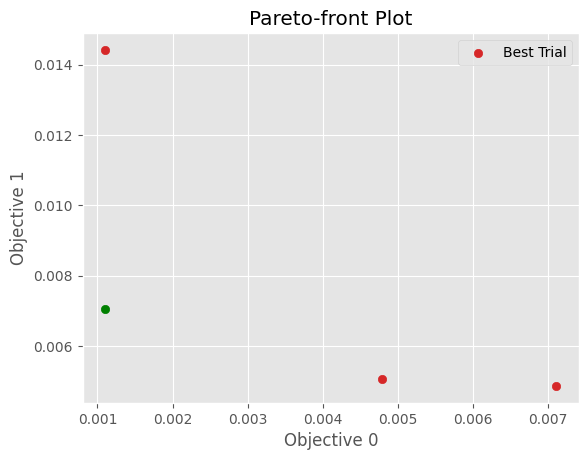

In [204]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(*attribs_focus.values(), color='green')

In [205]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

-11.046494965547323 0.22641365323134718
-10.271999503734948 0.4844045144562538
-10.627617136006098 0.5767726934056875


[0.001105658956279055, 0.014419393836414145]


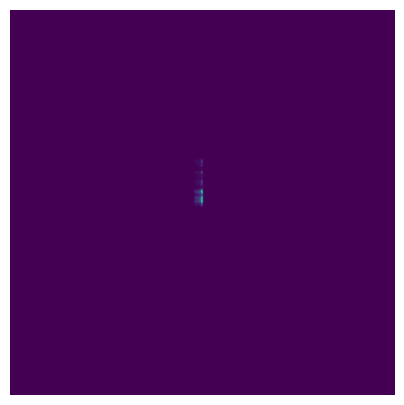

[0.007106483961563491, 0.0048671251908381265]


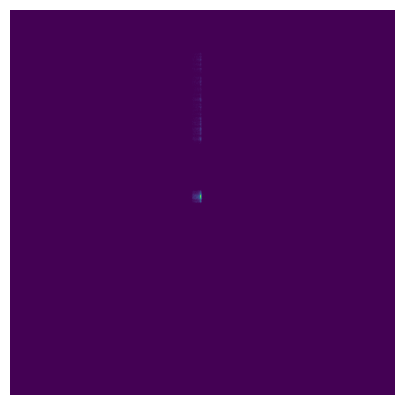

[0.004783842393766817, 0.005066495472542296]


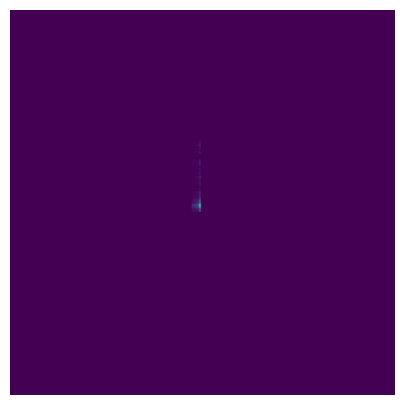

In [207]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    # for mot in opt_trial.motor_types:
    #    current_params.append(params[mot])
    # opt_trial._loss_fn_this(current_params)
    # print(t.values)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    print(vals)
    plt.figure(figsize=[5, 5])
    plt.imshow(t.user_attrs["data_2D"][700:-700,700:-700])
    plt.axis("off")
    plt.show()

#### WITH weighted sum

In [281]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


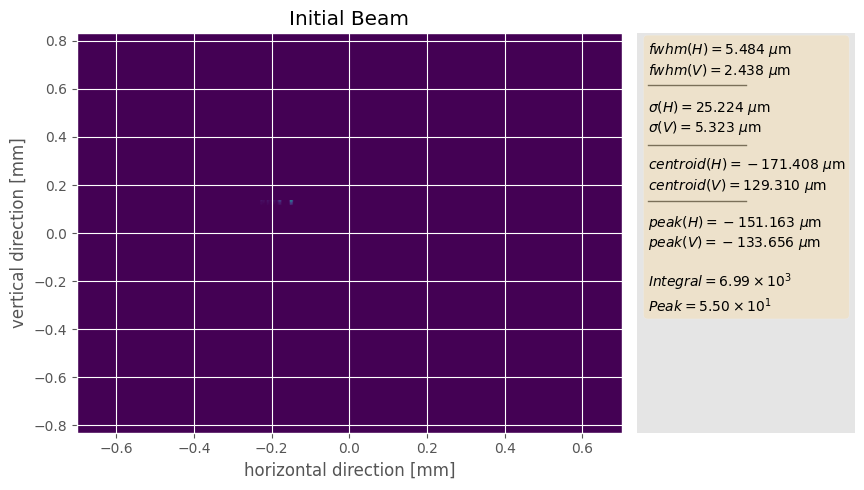

In [282]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(focusing_system=focusing_system, photon_beam=None, **sim_params.params)
plot_distribution(
    beam=beam_pert,
    title="Initial Beam",
    plot_mode=plot_mode,
    aspect_ratio=aspect_ratio,
    color_map=color_map,
    **sim_params.params,
)

In [283]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system peak: 2.023e-01
Perturbed beam system fwhm: 6.002e-03


In [284]:
opt_params.params["loss_parameters"]

['peak', 'fwhm']

In [285]:
# Now the optimization
opt_trial = OptunaOptimizer(
    focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=['peak', 'fwhm', 'weighted_sum_intensity'],#opt_params.params["loss_parameters"],
    reference_parameters_h_v=opt_params.params["reference_parameters_h_v"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    **sim_params.params,
    )

In [286]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds={"peak": 0.02, "fwhm": 0.02, "weighted_sum_intensity":0.},
)

[I 2022-11-18 03:08:08,909] A new study created in memory with name: no-name-63094a3d-9322-44bd-8c4a-a8872d089e21


In [287]:
n1 = 25#opt_params.params["n_pitch_trans_motor_trials"]
print(f"First optimizing only the pitch and translation motors for {n1} trials.")

opt_trial.trials(n1, trial_motor_types=["hb_pitch", "hb_trans", "vb_pitch", "vb_trans"])

/Users/skandel/code/oasys/AI-ML_Control_System/aps/ai/autoalignment/beamline28IDB/optimization/optuna_botorch.py:341: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
[I 2022-11-18 03:08:09,959] Trial 0 finished with values: [0.20231688826371, 0.006001647722969616, 5.299748193512047] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. 


First optimizing only the pitch and translation motors for 25 trials.


[I 2022-11-18 03:08:10,120] Trial 1 finished with values: [0.18570864592912378, 0.006825120906667449, 5.837164432365856] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': 0.014200000000000004, 'vb_bender': 0.0, 'vb_pitch': -0.00074, 'vb_trans': -0.017099999999999997}. 
[I 2022-11-18 03:08:10,277] Trial 2 finished with values: [0.2520288583962474, 0.005382393298830218, 5.653642627638949] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.015499999999999998, 'vb_bender': 0.0, 'vb_pitch': -0.0002999999999999999, 'vb_trans': 0.0022000000000000006}. 
[I 2022-11-18 03:08:10,437] Trial 3 finished with values: [0.29748100761408347, 0.006001647722969616, 6.747467799012595] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': -0.029599999999999998, 'vb_bender': 0.0, 'vb_pitch': -0.00152, 'vb_trans': 0.019300000000000005}. 
[I 2022-11-18 03:08:10,593] Trial 4 finished with valu

Pruning trial with parameters [0.0, 0.0, 0.0019, -0.0236, 0.0, 2.0000000000000052e-05, -0.0269]


[I 2022-11-18 03:08:11,061] Trial 7 finished with values: [0.14856240689696398, 0.00638032608442578, 3.1777663820176003] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': -0.0298, 'vb_bender': 0.0, 'vb_pitch': 0.0012600000000000003, 'vb_trans': 0.016600000000000004}. 
[I 2022-11-18 03:08:11,219] Trial 8 finished with values: [0.19522977912564424, 0.0062231898728548765, 2.423607763828831] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.0257, 'vb_bender': 0.0, 'vb_pitch': 0.0015600000000000002, 'vb_trans': 0.0262}. 
[I 2022-11-18 03:08:11,376] Trial 9 finished with values: [0.38149025828996364, 0.008845271650232604, 7.052156824738841] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.012899999999999998, 'vb_bender': 0.0, 'vb_pitch': -0.00188, 'vb_trans': 0.0299}. 
[I 2022-11-18 03:08:11,535] Trial 10 finished with values: [0.2754576191938825, 0.0068251209066

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_40708/384703890.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes3DSubplot:title={'center':'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

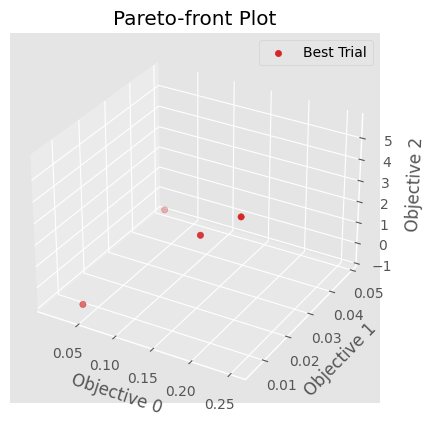

In [288]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [289]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

-4.870533782946829 285.3289221612685
-5.312167910345228 72.78069247869585
nan 0.5028794062421537
nan 0.4999170908930166


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_40708/2890865355.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(vals).sum(), t.user_attrs['ws'])


[0.2520288583962474, 0.005382393298830218, 5.653642627638949]


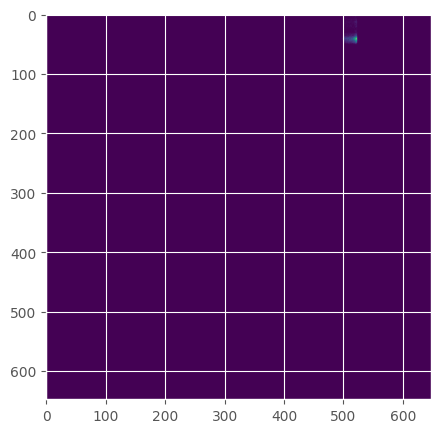

[0.20107388895001257, 0.00572005193513359, 4.287450706822671]


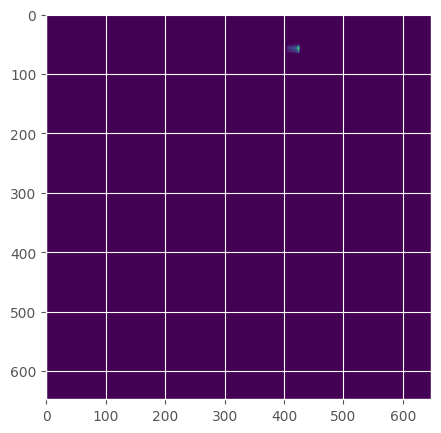

[0.042894800813218906, 0.0062231898728548765, -0.6874048866483522]


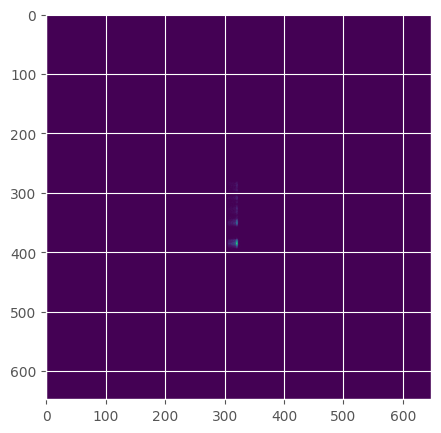

[0.01216781297709527, 0.04870094628795245, -0.693313012523272]


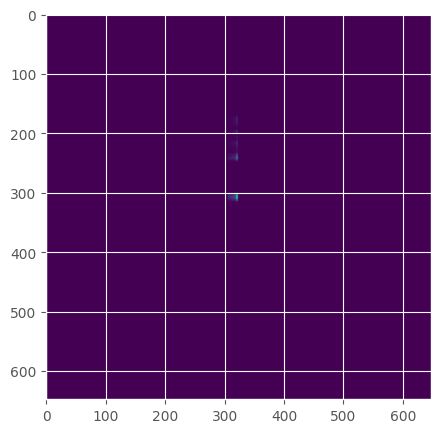

In [290]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    # for mot in opt_trial.motor_types:
    #    current_params.append(params[mot])
    # opt_trial._loss_fn_this(current_params)
    # print(t.values)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    print(vals)
    plt.figure(figsize=[5, 5])
    plt.imshow(t.user_attrs["data_2D"][700:-700,700:-700])
    #plt.axis("off")
    plt.show()

In [291]:
n2 = 50#opt_params.params["n_all_motor_trials"]
print(f"Optimizing all motors together for {n2} trials.")
opt_trial.trials(n2)

Optimizing all motors together for 50 trials.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:08:53,555] Trial 25 finished with values: [0.0709645677793085, 0.00572005193513359, -0.7394583727787284] and parameters: {'hb_1': -3.0, 'hb_2': -3.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': 0.0038000000000000048, 'vb_bender': 2.0, 'vb_pitch': 0.00198, 'vb_trans': 0.0257}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:08:56,412] Trial 26 finished with values: [0.3159849440829786, 0.035879172265276746, 6.645248289307172] and parameters: {'hb_1': 4.0, 'hb_2': 10.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.0097, 'vb_bender': 1.0, 'vb_pitch': -0.0012599999999999998, 'vb_trans': 0.019300000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:08:59,098] Trial 27 finished with values: [0.29999920127921276, 0.06265633063942196, 6.7935103534561305] and parameters: {'hb_1': 23.0, 'hb_2': -25.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': -0.008899999999999998, 'vb_bender': 16.0, 'vb_pitch': -0.00172, 'vb_trans': 0.0067000000000000046}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:09:01,359] Trial 28 finished with values: [0.2857900741407827, 0.03634306779583608, 6.00732419973981] and parameters: {'hb_1': -3.0, 'hb_2': -10.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.017499999999999998, 'vb_bender': -14.0, 'vb_pitch': -0.00082, 'vb_trans': -0.008399999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:09:03,640] Trial 29 finished with values: [0.026221057758454944, 0.028804430313555455, 1.577536199912341] and parameters: {'hb_1': -5.0, 'hb_2': -7.0, 'hb_pitch': 0.0013, 'hb_trans': -0.0127, 'vb_bender': -11.0, 'vb_pitch': 0.0017000000000000001, 'vb_trans': 0.026600000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:09:07,841] Trial 30 finished with values: [0.020693004993610455, 0.02752999518281147, 0.19272735061305235] and parameters: {'hb_1': 0.0, 'hb_2': -2.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': -0.002999999999999999, 'vb_bender': -3.0, 'vb_pitch': 0.00198, 'vb_trans': 0.019500000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:09:10,256] Trial 31 finished with values: [0.03807330991835007, 0.06845474956633574, 0.303720567808929] and parameters: {'hb_1': -8.0, 'hb_2': -7.0, 'hb_pitch': 0.001, 'hb_trans': 0.009800000000000003, 'vb_bender': 8.0, 'vb_pitch': 0.0018200000000000004, 'vb_trans': 0.0194}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:09:13,107] Trial 32 finished with values: [0.23533318587691182, 0.0302623870960951, 5.794775926024818] and parameters: {'hb_1': 9.0, 'hb_2': 12.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': 0.0075, 'vb_bender': 0.0, 'vb_pitch': -0.00031999999999999997, 'vb_trans': 0.008700000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:09:16,629] Trial 33 finished with values: [0.028879826939056382, 0.02231048660383726, 1.3619096568683318] and parameters: {'hb_1': 2.0, 'hb_2': 2.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': -0.0032999999999999974, 'vb_bender': 4.0, 'vb_pitch': 0.0017400000000000002, 'vb_trans': 0.026400000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:09:19,456] Trial 34 finished with values: [0.025183535602278238, 0.02752999518281147, -0.7268128072511946] and parameters: {'hb_1': -3.0, 'hb_2': 7.0, 'hb_pitch': 0.0013, 'hb_trans': -0.0016999999999999967, 'vb_bender': -12.0, 'vb_pitch': 0.0017400000000000002, 'vb_trans': 0.006600000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:09:21,843] Trial 35 finished with values: [0.17849919667049835, 0.06627233291492239, 5.363453887809517] and parameters: {'hb_1': -25.0, 'hb_2': 10.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': -0.005699999999999997, 'vb_bender': 17.0, 'vb_pitch': -2.0000000000000052e-05, 'vb_trans': 0.002800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:09:24,305] Trial 36 finished with values: [0.23601774343166812, 0.034816833774232364, 0.2100882472475339] and parameters: {'hb_1': -3.0, 'hb_2': -9.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': -0.017299999999999996, 'vb_bender': -17.0, 'vb_pitch': 0.0015, 'vb_trans': -0.006099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:09:26,796] Trial 37 finished with values: [0.009327323073992037, 0.05281211547711565, -0.43442146485212446] and parameters: {'hb_1': -9.0, 'hb_2': 7.0, 'hb_pitch': 0.0015, 'hb_trans': 0.014100000000000001, 'vb_bender': -8.0, 'vb_pitch': 0.0016200000000000003, 'vb_trans': 0.006400000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:09:29,605] Trial 38 finished with values: [0.01001486365032649, 0.007045429495937562, -0.8905709562718562] and parameters: {'hb_1': -7.0, 'hb_2': 0.0, 'hb_pitch': 0.0013, 'hb_trans': 0.0015000000000000013, 'vb_bender': 1.0, 'vb_pitch': 0.00186, 'vb_trans': 0.016300000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:09:33,063] Trial 39 finished with values: [0.01152740666712589, 0.032198075714426164, 0.13804801853800105] and parameters: {'hb_1': -10.0, 'hb_2': 5.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.0020000000000000018, 'vb_bender': -15.0, 'vb_pitch': 0.0018200000000000004, 'vb_trans': 0.010600000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:09:36,226] Trial 40 finished with values: [0.18707130209278106, 0.09393213590026193, 5.865289008183644] and parameters: {'hb_1': 17.0, 'hb_2': -9.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': 0.024200000000000006, 'vb_bender': 7.0, 'vb_pitch': -0.00076, 'vb_trans': -0.016599999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:09:39,209] Trial 41 finished with values: [0.004722673313561222, 0.012342063923859668, -0.06308480865481791] and parameters: {'hb_1': -7.0, 'hb_2': -6.0, 'hb_pitch': 0.0013, 'hb_trans': -0.008199999999999999, 'vb_bender': -14.0, 'vb_pitch': 0.0017000000000000001, 'vb_trans': -9.999999999999593e-05}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:09:42,234] Trial 42 finished with values: [0.05866695115804325, 0.010001199268908415, 0.807745285995836] and parameters: {'hb_1': -7.0, 'hb_2': 3.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': 0.008600000000000003, 'vb_bender': -15.0, 'vb_pitch': 0.0015400000000000001, 'vb_trans': 0.0039000000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:09:45,786] Trial 43 finished with values: [0.027444649514330066, 0.014686781196050231, 1.2607893877778102] and parameters: {'hb_1': -21.0, 'hb_2': 4.0, 'hb_pitch': 0.0013, 'hb_trans': 0.008800000000000002, 'vb_bender': -17.0, 'vb_pitch': 0.0015800000000000002, 'vb_trans': 0.010300000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:09:48,911] Trial 44 finished with values: [0.06964109340250871, 0.08983971341560401, -2.855439050562866] and parameters: {'hb_1': -9.0, 'hb_2': -12.0, 'hb_pitch': 0.0019, 'hb_trans': 0.011200000000000002, 'vb_bender': -5.0, 'vb_pitch': 0.0018800000000000002, 'vb_trans': 0.022400000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:09:52,867] Trial 45 finished with values: [0.0022767123726110043, 0.00572005193513359, -2.4773923349364395] and parameters: {'hb_1': -11.0, 'hb_2': -1.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.005600000000000001, 'vb_bender': -7.0, 'vb_pitch': 0.0017800000000000003, 'vb_trans': 0.013500000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:09:56,281] Trial 46 finished with values: [0.048553064566240284, 0.006001647722969616, -0.11171476107334952] and parameters: {'hb_1': -21.0, 'hb_2': -4.0, 'hb_pitch': 0.0018, 'hb_trans': 0.010800000000000004, 'vb_bender': -5.0, 'vb_pitch': 0.00168, 'vb_trans': 0.013300000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:09:59,493] Trial 47 finished with values: [0.020446726008564255, 0.07065338679657467, 1.150949698520046] and parameters: {'hb_1': -9.0, 'hb_2': 5.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.023700000000000006, 'vb_bender': -6.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': 0.0143}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:10:02,827] Trial 48 finished with values: [0.060127853428945166, 0.016769830266996317, 0.033498582724297905] and parameters: {'hb_1': -4.0, 'hb_2': -6.0, 'hb_pitch': 0.0018, 'hb_trans': -0.025099999999999997, 'vb_bender': -17.0, 'vb_pitch': 0.0016200000000000003, 'vb_trans': 0.0008000000000000021}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:10:06,707] Trial 49 finished with values: [0.02955763486867389, 0.008979562442374349, 1.362786699819115] and parameters: {'hb_1': -13.0, 'hb_2': 2.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.005500000000000005, 'vb_bender': 4.0, 'vb_pitch': 0.0015400000000000001, 'vb_trans': 0.010400000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:10:10,767] Trial 50 finished with values: [0.005430166714604674, 0.0055442335259822, -0.3973353028049493] and parameters: {'hb_1': -11.0, 'hb_2': -3.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.0034000000000000002, 'vb_bender': -8.0, 'vb_pitch': 0.0018000000000000004, 'vb_trans': 0.007400000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:10:14,882] Trial 51 finished with values: [0.015557974682137155, 0.04045542550498386, -2.3602958528691653] and parameters: {'hb_1': -2.0, 'hb_2': -6.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': -0.003599999999999999, 'vb_bender': -2.0, 'vb_pitch': 0.0017400000000000002, 'vb_trans': 0.009800000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:10:19,100] Trial 52 finished with values: [0.366239788114856, 0.047995159064004464, 5.337302357130144] and parameters: {'hb_1': -5.0, 'hb_2': 24.0, 'hb_pitch': -0.0016, 'hb_trans': -0.009899999999999999, 'vb_bender': -3.0, 'vb_pitch': -0.00021999999999999993, 'vb_trans': -0.012999999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:10:23,081] Trial 53 finished with values: [0.038928724166400544, 0.10832859496880304, 1.600172076610992] and parameters: {'hb_1': -11.0, 'hb_2': -19.0, 'hb_pitch': 0.0015, 'hb_trans': 0.007800000000000001, 'vb_bender': -9.0, 'vb_pitch': 0.00152, 'vb_trans': 0.011700000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:10:27,112] Trial 54 finished with values: [0.20563968644726144, 0.03679314459096893, 4.816703138758339] and parameters: {'hb_1': 4.0, 'hb_2': 24.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': 0.014700000000000005, 'vb_bender': 11.0, 'vb_pitch': 0.00042000000000000023, 'vb_trans': 0.0046}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:10:31,204] Trial 55 finished with values: [0.022372674426904583, 0.010486051468052473, 0.8337042678124311] and parameters: {'hb_1': -20.0, 'hb_2': 1.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': -0.004499999999999997, 'vb_bender': -17.0, 'vb_pitch': 0.0018400000000000005, 'vb_trans': 0.007000000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:10:35,316] Trial 56 finished with values: [0.014419779450665075, 0.024799765751870612, 0.7331841182248026] and parameters: {'hb_1': -9.0, 'hb_2': 9.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': -0.0076999999999999985, 'vb_bender': -3.0, 'vb_pitch': 0.0016400000000000004, 'vb_trans': 0.0148}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:10:39,714] Trial 57 finished with values: [0.005800757657911792, 0.006001647722969616, -0.5672941865472539] and parameters: {'hb_1': -12.0, 'hb_2': -2.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.0003999999999999976, 'vb_bender': -5.0, 'vb_pitch': 0.0018800000000000002, 'vb_trans': 0.014500000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:10:44,361] Trial 58 finished with values: [0.04185638370341615, 0.013806897990819878, 2.976312963882329] and parameters: {'hb_1': -4.0, 'hb_2': 5.0, 'hb_pitch': 0.0015, 'hb_trans': -0.009199999999999996, 'vb_bender': -6.0, 'vb_pitch': 0.0014200000000000003, 'vb_trans': 0.024800000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:10:49,140] Trial 59 finished with values: [0.01693952915663243, 0.04801578659492199, 0.5011052594549689] and parameters: {'hb_1': 1.0, 'hb_2': -3.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.007200000000000005, 'vb_bender': -13.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': 0.007600000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:10:53,385] Trial 60 finished with values: [0.026185924710256395, 0.02448437071546415, -0.2045307757608115] and parameters: {'hb_1': -20.0, 'hb_2': -9.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.005299999999999999, 'vb_bender': -14.0, 'vb_pitch': 0.0019399999999999999, 'vb_trans': 0.025200000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:10:58,376] Trial 61 finished with values: [0.0015946141312556054, 0.006001647722969616, -2.2034729303648164] and parameters: {'hb_1': -13.0, 'hb_2': -1.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.0036999999999999984, 'vb_bender': -6.0, 'vb_pitch': 0.0017800000000000003, 'vb_trans': 0.010600000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:11:03,075] Trial 62 finished with values: [0.036031848819782275, 0.006633953737674453, 2.224209233832018] and parameters: {'hb_1': -8.0, 'hb_2': 0.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': -0.012899999999999998, 'vb_bender': -7.0, 'vb_pitch': 0.0014200000000000003, 'vb_trans': 0.011700000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:11:08,156] Trial 63 finished with values: [0.014168019940683734, 0.0062231898728548765, 0.8837307067242893] and parameters: {'hb_1': -16.0, 'hb_2': -1.0, 'hb_pitch': 0.0015, 'hb_trans': -0.0214, 'vb_bender': -11.0, 'vb_pitch': 0.0018400000000000005, 'vb_trans': 0.003500000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:11:12,942] Trial 64 pruned. 


Pruning trial with parameters [-24.0, -19.0, 0.0002000000000000001, -0.0219, -18.0, -9.999999999999983e-05, -0.0272]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:11:18,362] Trial 65 finished with values: [0.008141259518311295, 0.005066495472542296, -3.157243937094538] and parameters: {'hb_1': -17.0, 'hb_2': -2.0, 'hb_pitch': 0.0013, 'hb_trans': 0.0019000000000000059, 'vb_bender': -5.0, 'vb_pitch': 0.0018000000000000004, 'vb_trans': 0.015100000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:11:23,041] Trial 66 finished with values: [0.23897942236775055, 0.024892759491419506, 6.4301211203418225] and parameters: {'hb_1': -17.0, 'hb_2': -9.0, 'hb_pitch': 0.001, 'hb_trans': -0.004099999999999996, 'vb_bender': -1.0, 'vb_pitch': -0.0014, 'vb_trans': -0.010199999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:11:28,944] Trial 67 finished with values: [0.03875256773532082, 0.020710346986229818, -3.011251966799995] and parameters: {'hb_1': -6.0, 'hb_2': 20.0, 'hb_pitch': 0.0018, 'hb_trans': -0.015599999999999998, 'vb_bender': -6.0, 'vb_pitch': 0.0017600000000000003, 'vb_trans': 0.011300000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:11:33,767] Trial 68 finished with values: [0.2769656653229772, 0.14584813715464795, 6.709455587825661] and parameters: {'hb_1': -21.0, 'hb_2': -20.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.027800000000000005, 'vb_bender': 9.0, 'vb_pitch': -0.00162, 'vb_trans': -9.999999999999593e-05}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:11:39,223] Trial 69 finished with values: [0.00367228235460665, 0.00572005193513359, -2.244846035760359] and parameters: {'hb_1': -15.0, 'hb_2': 1.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.0072999999999999975, 'vb_bender': -4.0, 'vb_pitch': 0.0017800000000000003, 'vb_trans': 0.015400000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:11:44,207] Trial 70 finished with values: [0.30413800231915944, 0.04245288961974974, -0.2988698344276491] and parameters: {'hb_1': 24.0, 'hb_2': 2.0, 'hb_pitch': -0.0014, 'hb_trans': -0.022799999999999997, 'vb_bender': 5.0, 'vb_pitch': 0.0015400000000000001, 'vb_trans': -0.007899999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:11:49,292] Trial 71 finished with values: [0.07986897152999009, 0.05144168822803379, 1.5495943238461198] and parameters: {'hb_1': -3.0, 'hb_2': 16.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': 0.009600000000000004, 'vb_bender': -11.0, 'vb_pitch': 0.0012400000000000002, 'vb_trans': -0.012299999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:11:54,615] Trial 72 finished with values: [0.17613084416274183, 0.06959829679247351, 5.970462560873655] and parameters: {'hb_1': -8.0, 'hb_2': -23.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': -0.0162, 'vb_bender': 16.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': 0.023000000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:12:00,246] Trial 73 finished with values: [0.05134116380694278, 0.07556756771690744, 1.675090594697562] and parameters: {'hb_1': 14.0, 'hb_2': 0.0, 'hb_pitch': 0.001, 'hb_trans': 0.029500000000000005, 'vb_bender': 2.0, 'vb_pitch': 0.00102, 'vb_trans': -0.0275}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:12:06,118] Trial 74 finished with values: [0.013667286653334504, 0.005066495472542296, -2.057244877887288] and parameters: {'hb_1': -17.0, 'hb_2': -2.0, 'hb_pitch': 0.0015, 'hb_trans': 0.006200000000000004, 'vb_bender': -8.0, 'vb_pitch': 0.0017800000000000003, 'vb_trans': 0.013500000000000005}. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_40708/384703890.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes3DSubplot:title={'center':'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

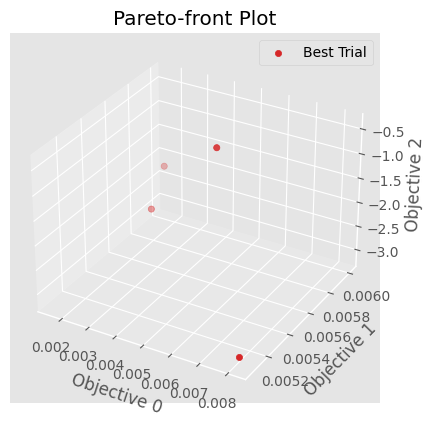

In [292]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [293]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

nan 0.08396188484702703
nan 0.6721086279383511
nan 0.11041901414829719
nan 0.04254283037034791


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_40708/2890865355.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(vals).sum(), t.user_attrs['ws'])


[0.0022767123726110043, 0.00572005193513359, -2.4773923349364395]


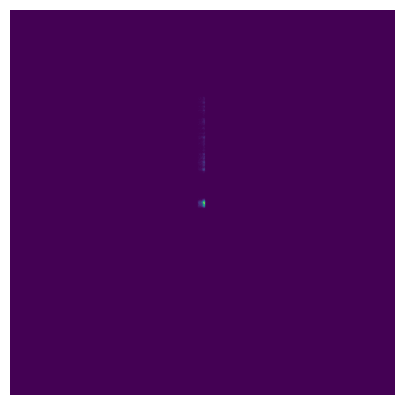

[0.005430166714604674, 0.0055442335259822, -0.3973353028049493]


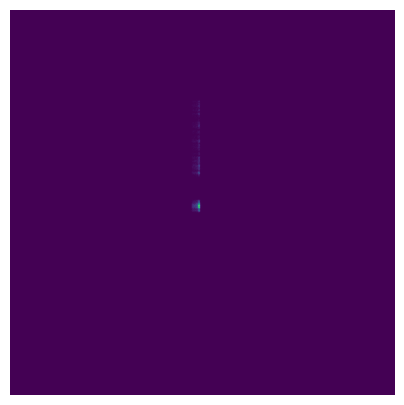

[0.0015946141312556054, 0.006001647722969616, -2.2034729303648164]


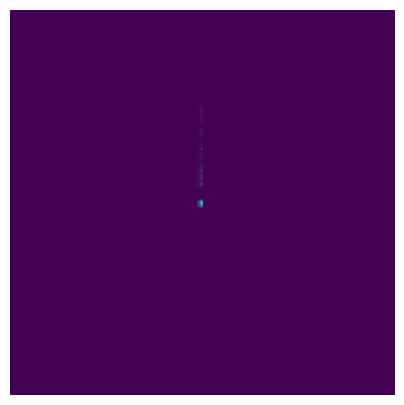

[0.008141259518311295, 0.005066495472542296, -3.157243937094538]


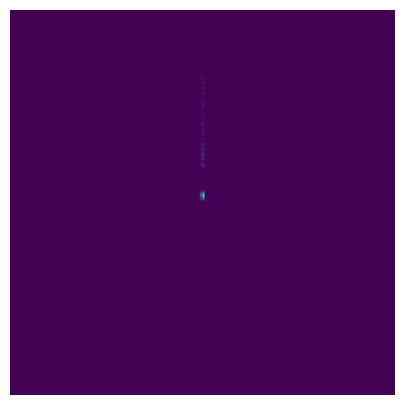

In [294]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    # for mot in opt_trial.motor_types:
    #    current_params.append(params[mot])
    # opt_trial._loss_fn_this(current_params)
    # print(t.values)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    print(vals)
    plt.figure(figsize=[5, 5])
    plt.imshow(t.user_attrs["data_2D"][700:-700,700:-700])
    plt.axis("off")
    plt.show()

####  with peak amd fwhm starting from the focused structure

In [295]:
input_beam_path = "primary_optics_system_beam.dat"

clean_up()

# Initializing the focused beam from simulation
input_features = get_default_input_features(layout=Layout.AUTO_FOCUSING)
input_beam = load_shadow_beam(input_beam_path)
focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=True,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    layout=Layout.AUTO_FOCUSING,
    input_features=input_features,
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


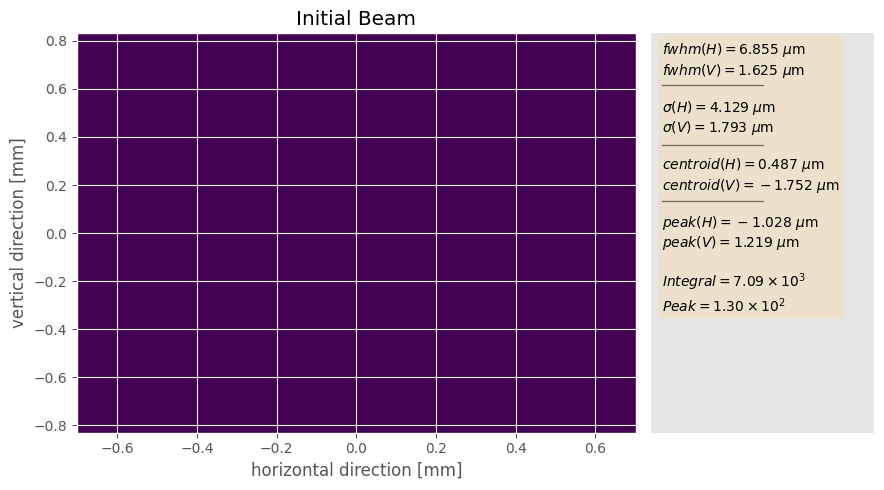

In [296]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(focusing_system=focusing_system, photon_beam=None, **sim_params.params)
plot_distribution(
    beam=beam_pert,
    title="Initial Beam",
    plot_mode=plot_mode,
    aspect_ratio=aspect_ratio,
    color_map=color_map,
    **sim_params.params,
)

In [297]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system peak: 1.106e-03
Perturbed beam system fwhm: 7.045e-03


In [298]:
# Now the optimization
opt_trial = OptunaOptimizer(
    focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    reference_parameters_h_v=opt_params.params["reference_parameters_h_v"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    **sim_params.params,
    )

In [299]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds={"peak": 0.01, "fwhm": 0.01},
)

[I 2022-11-18 03:15:08,258] A new study created in memory with name: no-name-bba6f2e1-f35f-4f17-a45c-afaa6e3006da


In [300]:
n1 = 25#opt_params.params["n_pitch_trans_motor_trials"]
print(f"First optimizing only the pitch and translation motors for {n1} trials.")

opt_trial.trials(n1, trial_motor_types=["hb_pitch", "hb_trans", "vb_pitch", "vb_trans"])

/Users/skandel/code/oasys/AI-ML_Control_System/aps/ai/autoalignment/beamline28IDB/optimization/optuna_botorch.py:341: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2022-11-18 0

First optimizing only the pitch and translation motors for 25 trials.


[I 2022-11-18 03:15:09,823] Trial 1 finished with values: [0.10501577924056688, 0.006001647722969616] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': 0.014200000000000004, 'vb_bender': 0.0, 'vb_pitch': -0.00074, 'vb_trans': -0.017099999999999997}. 
[I 2022-11-18 03:15:09,974] Trial 2 finished with values: [0.05109062073250414, 0.006001647722969616] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.015499999999999998, 'vb_bender': 0.0, 'vb_pitch': -0.0002999999999999999, 'vb_trans': 0.0022000000000000006}. 
[I 2022-11-18 03:15:10,121] Trial 3 pruned. 
[I 2022-11-18 03:15:10,278] Trial 4 finished with values: [0.11253594834197474, 0.00638032608442578] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': -0.007399999999999997, 'vb_bender': 0.0, 'vb_pitch': -0.00106, 'vb_trans': 0.029000000000000005}. 


Pruning trial with parameters [0.0, 0.0, 0.0004000000000000002, -0.029599999999999998, 0.0, -0.00152, 0.019300000000000005]


[I 2022-11-18 03:15:10,429] Trial 5 pruned. 
[I 2022-11-18 03:15:10,589] Trial 6 finished with values: [0.12581994246458345, 0.006001647722969616] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': -0.001, 'hb_trans': 0.0109, 'vb_bender': 0.0, 'vb_pitch': -0.00076, 'vb_trans': 0.0040000000000000036}. 


Pruning trial with parameters [0.0, 0.0, 0.0019, -0.0236, 0.0, 2.0000000000000052e-05, -0.0269]


[I 2022-11-18 03:15:10,739] Trial 7 pruned. 
[I 2022-11-18 03:15:10,884] Trial 8 pruned. 


Pruning trial with parameters [0.0, 0.0, 0.00010000000000000026, -0.0298, 0.0, 0.0012600000000000003, 0.016600000000000004]
Pruning trial with parameters [0.0, 0.0, -0.00039999999999999996, -0.0257, 0.0, 0.0015600000000000002, 0.0262]


[I 2022-11-18 03:15:11,043] Trial 9 finished with values: [0.19074393046760632, 0.00638032608442578] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.012899999999999998, 'vb_bender': 0.0, 'vb_pitch': -0.00188, 'vb_trans': 0.0299}. 
[I 2022-11-18 03:15:11,196] Trial 10 finished with values: [0.10834683456849242, 0.006633953737674453] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': -0.006799999999999997, 'vb_bender': 0.0, 'vb_pitch': -0.00156, 'vb_trans': -0.0189}. 
[I 2022-11-18 03:15:11,352] Trial 11 finished with values: [0.14443513717600487, 0.007045429495937562] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': 0.0025000000000000022, 'vb_bender': 0.0, 'vb_pitch': -0.0019, 'vb_trans': -0.014199999999999997}. 
[I 2022-11-18 03:15:11,506] Trial 12 finished with values: [0.04426440403227609, 0.006633953737674453] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_

Pruning trial with parameters [0.0, 0.0, 0.00010000000000000026, -0.0236, 0.0, -0.00021999999999999993, -0.0277]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2022-11-18 03:15:25,002] Trial 22 finished with values: [0.031073708812622412, 0.0077141131477632945] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': 0.0013000000000000025, 'vb_bender': 0.0, 'vb_pitch': -0.0005199999999999998, 'vb_trans': -0.0196}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Pyt

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_40708/1961813434.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


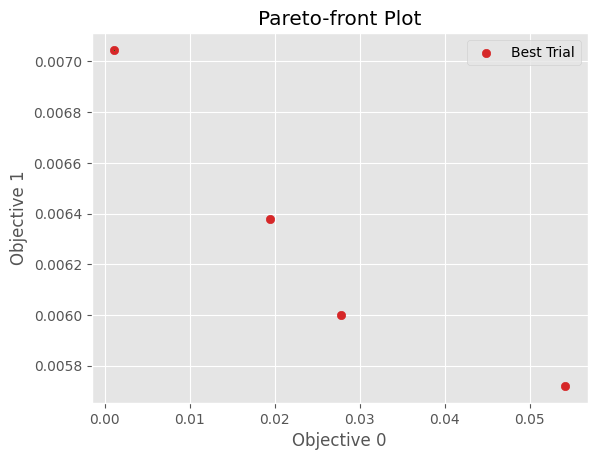

In [301]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(*attribs_focus.values(), color='green')

In [302]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

-11.76268995207158 0.07620546318277598
-8.079518033718728 10.040603538739036
-8.69931501268557 3.24538750483013
-8.997174003117255 2.8155942139859627


[0.001105658956279055, 0.007045429495937562]


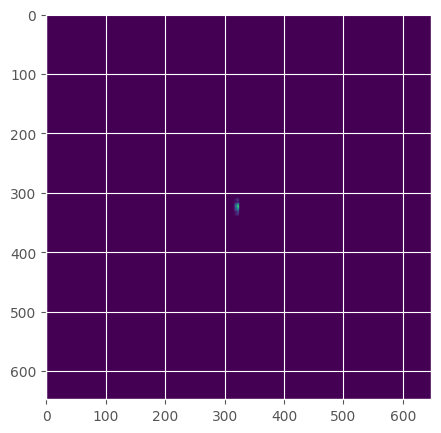

[0.054163900241143814, 0.00572005193513359]


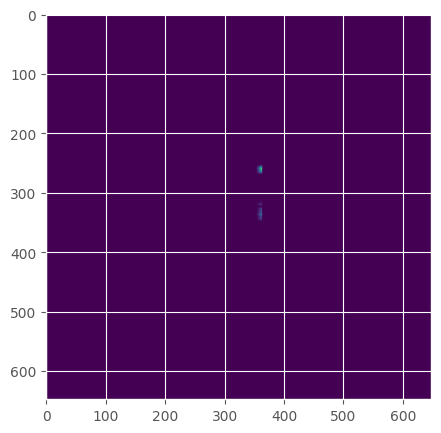

[0.02777569876477718, 0.006001647722969616]


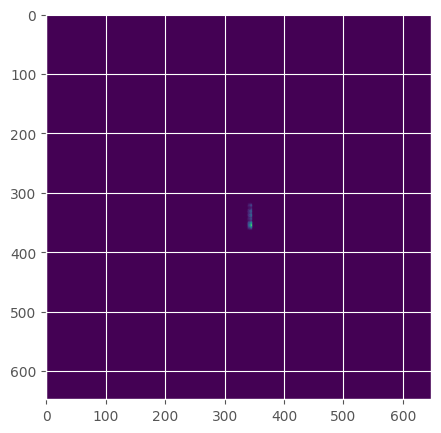

[0.019396979312115335, 0.00638032608442578]


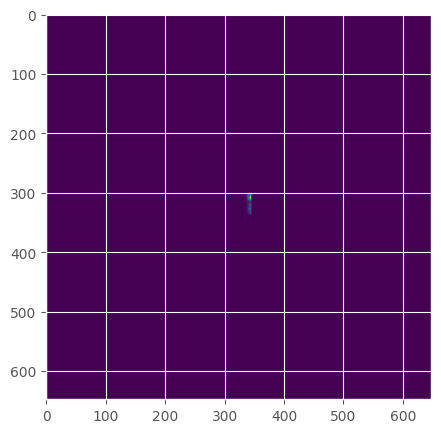

In [303]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    # for mot in opt_trial.motor_types:
    #    current_params.append(params[mot])
    # opt_trial._loss_fn_this(current_params)
    # print(t.values)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    print(vals)
    plt.figure(figsize=[5, 5])
    plt.imshow(t.user_attrs["data_2D"][700:-700,700:-700])
    #plt.axis("off")
    plt.show()

In [304]:
n2 = 50#opt_params.params["n_all_motor_trials"]
print(f"Optimizing all motors together for {n2} trials.")
opt_trial.trials(n2)

Optimizing all motors together for 50 trials.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:15:41,272] Trial 25 finished with values: [0.034375739308123154, 0.04801578659492199] and parameters: {'hb_1': -5.0, 'hb_2': -9.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': 0.003700000000000002, 'vb_bender': -5.0, 'vb_pitch': -5.999999999999994e-05, 'vb_trans': 0.009400000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:15:43,386] Trial 26 finished with values: [0.023738431843751892, 0.013126363774246001] and parameters: {'hb_1': -7.0, 'hb_2': 9.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.007000000000000006, 'vb_bender': 1.0, 'vb_pitch': -3.999999999999967e-05, 'vb_trans': -0.000899999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:15:45,261] Trial 27 finished with values: [0.02604536414384164, 0.00826658858395687] and parameters: {'hb_1': -18.0, 'hb_2': 3.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.008700000000000006, 'vb_bender': 4.0, 'vb_pitch': 0.00012000000000000031, 'vb_trans': -0.011199999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:15:47,390] Trial 28 finished with values: [0.07430110029045094, 0.00572005193513359] and parameters: {'hb_1': -24.0, 'hb_2': -1.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': 0.015100000000000002, 'vb_bender': 2.0, 'vb_pitch': -0.00082, 'vb_trans': 0.005700000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:15:49,542] Trial 29 finished with values: [0.03793257615691892, 0.007441532612526753] and parameters: {'hb_1': -9.0, 'hb_2': 4.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': 0.003600000000000006, 'vb_bender': 9.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': -0.0093}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:15:52,010] Trial 30 finished with values: [0.012848515538365145, 0.00638032608442578] and parameters: {'hb_1': -17.0, 'hb_2': 0.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': -0.023299999999999998, 'vb_bender': 3.0, 'vb_pitch': -0.00011999999999999988, 'vb_trans': -0.004299999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:15:54,720] Trial 31 finished with values: [0.0436877578596765, 0.05399879203434307] and parameters: {'hb_1': -11.0, 'hb_2': -1.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': -0.0293, 'vb_bender': 12.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': -0.0172}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:15:57,393] Trial 32 finished with values: [0.035715777055665456, 0.009631986386159594] and parameters: {'hb_1': -18.0, 'hb_2': 3.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': -0.011699999999999999, 'vb_bender': -6.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': 0.0005000000000000039}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:15:59,911] Trial 33 finished with values: [0.03679945410499779, 0.05038321544967553] and parameters: {'hb_1': -14.0, 'hb_2': -6.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': -0.004199999999999999, 'vb_bender': 19.0, 'vb_pitch': -0.0002999999999999999, 'vb_trans': -0.0028999999999999963}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:01,740] Trial 34 finished with values: [0.02570166250781427, 0.024842893880815176] and parameters: {'hb_1': -6.0, 'hb_2': -18.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.0024999999999999988, 'vb_bender': 15.0, 'vb_pitch': 0.00042000000000000023, 'vb_trans': 0.003700000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:03,696] Trial 35 finished with values: [0.004585539142521824, 0.00638032608442578] and parameters: {'hb_1': -24.0, 'hb_2': 1.0, 'hb_pitch': 0.0, 'hb_trans': -0.002399999999999996, 'vb_bender': 3.0, 'vb_pitch': 0.00013999999999999993, 'vb_trans': 0.0155}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:05,569] Trial 36 finished with values: [0.03726153806911927, 0.028978980042995657] and parameters: {'hb_1': 0.0, 'hb_2': 7.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': -0.0010999999999999968, 'vb_bender': 12.0, 'vb_pitch': -0.00035999999999999986, 'vb_trans': -0.006999999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:07,911] Trial 37 finished with values: [0.072517759745829, 0.10009314151403863] and parameters: {'hb_1': -25.0, 'hb_2': -21.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': 0.009500000000000001, 'vb_bender': 5.0, 'vb_pitch': -7.999999999999978e-05, 'vb_trans': -0.003199999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:10,336] Trial 38 finished with values: [0.009499631824386137, 0.006903448995409939] and parameters: {'hb_1': 15.0, 'hb_2': 2.0, 'hb_pitch': 0.0, 'hb_trans': -0.022899999999999997, 'vb_bender': 6.0, 'vb_pitch': 0.0002400000000000002, 'vb_trans': 0.0075}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:12,276] Trial 39 finished with values: [0.025426606584950325, 0.05497001704610021] and parameters: {'hb_1': -6.0, 'hb_2': 23.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': -0.0024999999999999988, 'vb_bender': 20.0, 'vb_pitch': 0.00034, 'vb_trans': -0.0116}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:14,525] Trial 40 finished with values: [0.03004459095097958, 0.010315251948450382] and parameters: {'hb_1': 21.0, 'hb_2': 4.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.0293, 'vb_bender': -3.0, 'vb_pitch': -9.999999999999983e-05, 'vb_trans': -0.0049999999999999975}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:17,049] Trial 41 finished with values: [0.0024335625954190537, 0.016473174512389034] and parameters: {'hb_1': -3.0, 'hb_2': 3.0, 'hb_pitch': 0.0, 'hb_trans': -0.003599999999999999, 'vb_bender': 5.0, 'vb_pitch': 6.000000000000016e-05, 'vb_trans': 0.0033000000000000043}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:18,964] Trial 42 pruned. 


Pruning trial with parameters [20.0, 3.0, 0.0004000000000000002, -0.027999999999999997, 2.0, 0.00013999999999999993, -0.023399999999999997]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:20,844] Trial 43 finished with values: [0.02560863558508815, 0.010998801426178198] and parameters: {'hb_1': 20.0, 'hb_2': -5.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': -0.004899999999999998, 'vb_bender': 5.0, 'vb_pitch': 0.00022000000000000014, 'vb_trans': -0.004499999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:22,821] Trial 44 finished with values: [0.0337496161686299, 0.010998801426178198] and parameters: {'hb_1': 0.0, 'hb_2': -3.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': -0.004199999999999999, 'vb_bender': -4.0, 'vb_pitch': 0.0002400000000000002, 'vb_trans': -0.011899999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:24,798] Trial 45 finished with values: [0.017606640959743375, 0.0055442335259822] and parameters: {'hb_1': 11.0, 'hb_2': -4.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.009400000000000006, 'vb_bender': 6.0, 'vb_pitch': 0.00034, 'vb_trans': 0.019800000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:26,818] Trial 46 finished with values: [0.0015946141312556054, 0.035657695557079955] and parameters: {'hb_1': 13.0, 'hb_2': 5.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.004900000000000002, 'vb_bender': 5.0, 'vb_pitch': 0.0002400000000000002, 'vb_trans': 0.019200000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:28,952] Trial 47 finished with values: [0.18901953236250504, 0.03504775495100518] and parameters: {'hb_1': -8.0, 'hb_2': 3.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': 0.017600000000000005, 'vb_bender': -1.0, 'vb_pitch': -0.0008799999999999999, 'vb_trans': 0.0031000000000000055}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:31,064] Trial 48 finished with values: [0.0492539399502627, 0.034948283815615246] and parameters: {'hb_1': -13.0, 'hb_2': 18.0, 'hb_pitch': 0.0, 'hb_trans': 0.017600000000000005, 'vb_bender': 17.0, 'vb_pitch': 0.0006400000000000004, 'vb_trans': 0.0058}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:33,087] Trial 49 finished with values: [0.009274436273434796, 0.013050707152634955] and parameters: {'hb_1': 5.0, 'hb_2': 20.0, 'hb_pitch': 0.0, 'hb_trans': 0.003500000000000003, 'vb_bender': 3.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': -0.006799999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:37,367] Trial 50 finished with values: [0.030725155865838065, 0.02537824405172033] and parameters: {'hb_1': 5.0, 'hb_2': 15.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': -0.004299999999999998, 'vb_bender': 4.0, 'vb_pitch': 0.00010000000000000026, 'vb_trans': 0.0033000000000000043}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:39,577] Trial 51 finished with values: [0.04259923601540013, 0.006001647722969616] and parameters: {'hb_1': 25.0, 'hb_2': 0.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': -0.018099999999999998, 'vb_bender': -1.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': -0.0174}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:42,346] Trial 52 finished with values: [0.058469754029486155, 0.10702244517844191] and parameters: {'hb_1': 15.0, 'hb_2': 24.0, 'hb_pitch': 0.0, 'hb_trans': -0.008199999999999999, 'vb_bender': 9.0, 'vb_pitch': 0.00038000000000000013, 'vb_trans': -0.008999999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:44,402] Trial 53 finished with values: [0.001266035225400756, 0.0055442335259822] and parameters: {'hb_1': 15.0, 'hb_2': -1.0, 'hb_pitch': 0.0, 'hb_trans': 0.009400000000000006, 'vb_bender': 5.0, 'vb_pitch': -0.00011999999999999988, 'vb_trans': -0.010899999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:46,569] Trial 54 finished with values: [0.018838376545905283, 0.05949170274343413] and parameters: {'hb_1': 22.0, 'hb_2': -9.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.025200000000000007, 'vb_bender': 19.0, 'vb_pitch': 0.00013999999999999993, 'vb_trans': -0.008599999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:48,823] Trial 55 finished with values: [0.028977102925148185, 0.026164567834866863] and parameters: {'hb_1': -6.0, 'hb_2': 1.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.013500000000000005, 'vb_bender': 1.0, 'vb_pitch': -0.00011999999999999988, 'vb_trans': 0.0182}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:52,857] Trial 56 finished with values: [0.0036936378474886743, 0.02537824405172033] and parameters: {'hb_1': 7.0, 'hb_2': -3.0, 'hb_pitch': 0.0, 'hb_trans': -0.005499999999999998, 'vb_bender': 4.0, 'vb_pitch': 4.0000000000000105e-05, 'vb_trans': 0.004300000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:56,360] Trial 57 finished with values: [0.0044818768604185525, 0.030945755845351145] and parameters: {'hb_1': 9.0, 'hb_2': -1.0, 'hb_pitch': 0.0, 'hb_trans': -0.005099999999999997, 'vb_bender': -1.0, 'vb_pitch': 0.0, 'vb_trans': 0.005200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:16:58,691] Trial 58 finished with values: [0.017498990520244284, 0.007045429495937562] and parameters: {'hb_1': -22.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': -0.023299999999999998, 'vb_bender': -5.0, 'vb_pitch': 4.0000000000000105e-05, 'vb_trans': 0.019500000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be repla

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:17:07,561] Trial 59 finished with values: [0.00962489739895919, 0.0063750191482557575] and parameters: {'hb_1': 15.0, 'hb_2': -3.0, 'hb_pitch': 0.0, 'hb_trans': -0.004299999999999998, 'vb_bender': 8.0, 'vb_pitch': 6.000000000000016e-05, 'vb_trans': 0.008400000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:17:10,710] Trial 60 finished with values: [0.0015946141312556054, 0.00638032608442578] and parameters: {'hb_1': 18.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': -0.000499999999999997, 'vb_bender': 3.0, 'vb_pitch': -9.999999999999983e-05, 'vb_trans': -0.007199999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:17:15,526] Trial 61 finished with values: [0.0005315380437518685, 0.00572005193513359] and parameters: {'hb_1': 15.0, 'hb_2': -1.0, 'hb_pitch': 0.0, 'hb_trans': -0.006099999999999998, 'vb_bender': 4.0, 'vb_pitch': -5.999999999999994e-05, 'vb_trans': -0.0063999999999999994}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:17:18,077] Trial 62 finished with values: [0.015656861831984108, 0.009140625000000745] and parameters: {'hb_1': 12.0, 'hb_2': -18.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': 0.009800000000000003, 'vb_bender': 10.0, 'vb_pitch': -0.00011999999999999988, 'vb_trans': -0.023}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:17:23,088] Trial 63 finished with values: [0.01889189192922685, 0.01460137557251438] and parameters: {'hb_1': 13.0, 'hb_2': -7.0, 'hb_pitch': 0.0, 'hb_trans': 0.0063, 'vb_bender': 7.0, 'vb_pitch': -9.999999999999983e-05, 'vb_trans': -0.0138}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:17:26,725] Trial 64 finished with values: [0.001266035225400756, 0.006633953737674453] and parameters: {'hb_1': 17.0, 'hb_2': 1.0, 'hb_pitch': 0.0, 'hb_trans': -0.003599999999999999, 'vb_bender': 7.0, 'vb_pitch': 0.0, 'vb_trans': -0.0026999999999999975}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:17:28,942] Trial 65 finished with values: [0.08176908866883913, 0.06485682664762156] and parameters: {'hb_1': 0.0, 'hb_2': 23.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.0221, 'vb_bender': -20.0, 'vb_pitch': -0.0005, 'vb_trans': 0.0033000000000000043}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:17:32,626] Trial 66 finished with values: [0.02422824806271681, 0.03154562150222926] and parameters: {'hb_1': 2.0, 'hb_2': 20.0, 'hb_pitch': 0.0, 'hb_trans': 0.0172, 'vb_bender': 5.0, 'vb_pitch': -7.999999999999978e-05, 'vb_trans': -0.0167}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:17:35,149] Trial 67 finished with values: [0.03687883395937543, 0.03773484265529317] and parameters: {'hb_1': -7.0, 'hb_2': 8.0, 'hb_pitch': 0.0, 'hb_trans': -0.010699999999999998, 'vb_bender': 11.0, 'vb_pitch': 0.00047999999999999996, 'vb_trans': -0.0022999999999999965}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:17:38,141] Trial 68 finished with values: [0.03483479240470608, 0.019576616452881706] and parameters: {'hb_1': 13.0, 'hb_2': -22.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.012100000000000007, 'vb_bender': 13.0, 'vb_pitch': 0.0002400000000000002, 'vb_trans': -0.010699999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:17:40,919] Trial 69 finished with values: [0.0044818768604185525, 0.0055442335259822] and parameters: {'hb_1': 16.0, 'hb_2': -1.0, 'hb_pitch': 0.0, 'hb_trans': -0.004299999999999998, 'vb_bender': 5.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': 0.004700000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:17:43,771] Trial 70 finished with values: [0.03354454485152478, 0.028305627725662617] and parameters: {'hb_1': 7.0, 'hb_2': -18.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': -0.006499999999999999, 'vb_bender': 16.0, 'vb_pitch': -0.00019999999999999987, 'vb_trans': 0.0019000000000000059}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:17:46,674] Trial 71 finished with values: [0.045406490285911066, 0.06864069835885929] and parameters: {'hb_1': 3.0, 'hb_2': 3.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.028700000000000003, 'vb_bender': 19.0, 'vb_pitch': 0.00026000000000000025, 'vb_trans': 0.028900000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:17:49,201] Trial 72 finished with values: [0.030960598193188114, 0.02103986752312693] and parameters: {'hb_1': 15.0, 'hb_2': -1.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': -0.006099999999999998, 'vb_bender': 13.0, 'vb_pitch': -7.999999999999978e-05, 'vb_trans': -0.0231}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:17:51,643] Trial 73 finished with values: [0.03597479956798377, 0.02684945444018107] and parameters: {'hb_1': -7.0, 'hb_2': 10.0, 'hb_pitch': 0.0, 'hb_trans': 0.017900000000000006, 'vb_bender': 10.0, 'vb_pitch': 0.00012000000000000031, 'vb_trans': -0.004499999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 03:17:54,090] Trial 74 finished with values: [0.030597338722166183, 0.06376103638504282] and parameters: {'hb_1': -11.0, 'hb_2': 10.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': -0.0243, 'vb_bender': 4.0, 'vb_pitch': -5.999999999999994e-05, 'vb_trans': -0.015499999999999998}. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_40708/1961813434.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


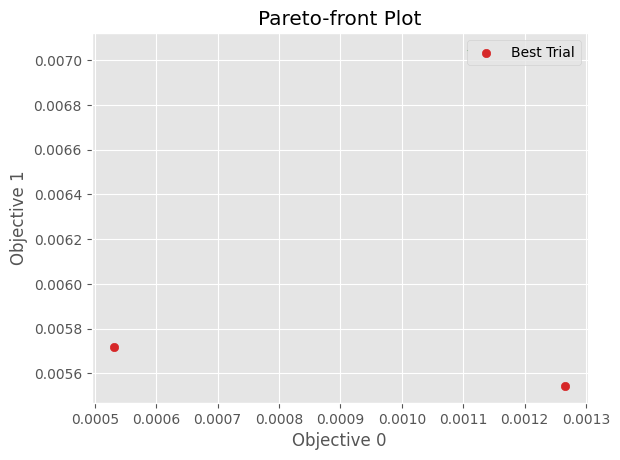

In [305]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(*attribs_focus.values(), color='green')

In [306]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

-11.866862027166516 0.3380694370753647
-12.703513178722282 0.2802880355655188


[0.001266035225400756, 0.0055442335259822]


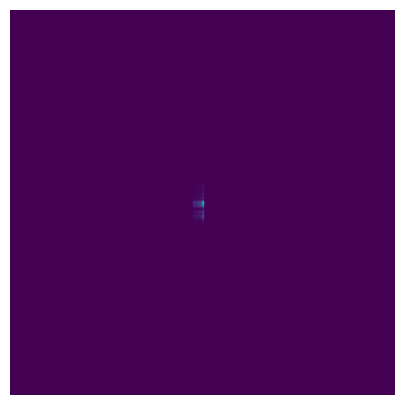

[0.0005315380437518685, 0.00572005193513359]


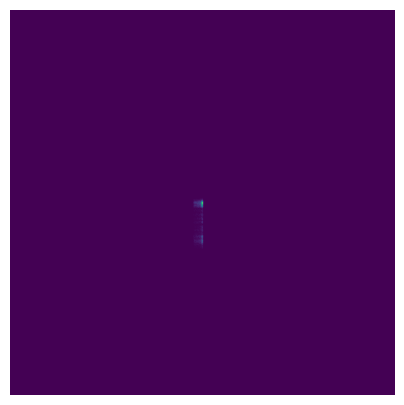

In [307]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    # for mot in opt_trial.motor_types:
    #    current_params.append(params[mot])
    # opt_trial._loss_fn_this(current_params)
    # print(t.values)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    print(vals)
    plt.figure(figsize=[5, 5])
    plt.imshow(t.user_attrs["data_2D"][700:-700,700:-700])
    plt.axis("off")
    plt.show()

#### WITH weighted sum

In [308]:
input_beam_path = "primary_optics_system_beam.dat"

clean_up()

# Initializing the focused beam from simulation
input_features = get_default_input_features(layout=Layout.AUTO_FOCUSING)
input_beam = load_shadow_beam(input_beam_path)
focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=True,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    layout=Layout.AUTO_FOCUSING,
    input_features=input_features,
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


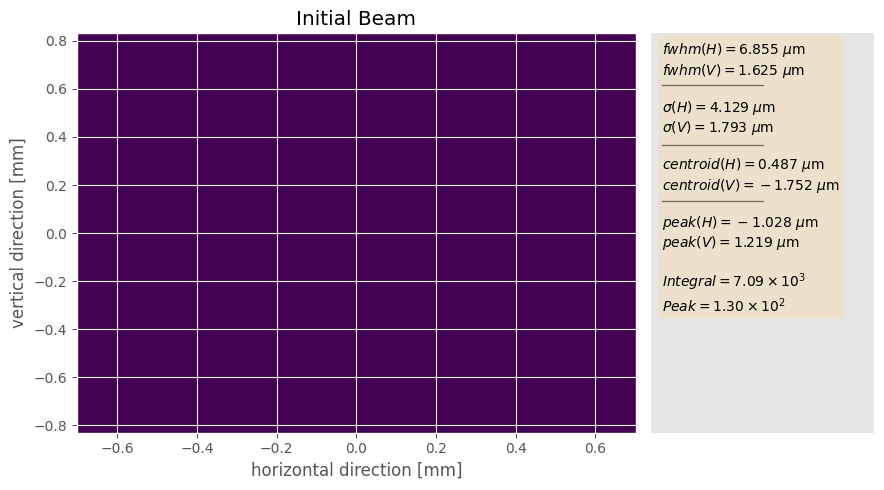

In [309]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(focusing_system=focusing_system, photon_beam=None, **sim_params.params)
plot_distribution(
    beam=beam_pert,
    title="Initial Beam",
    plot_mode=plot_mode,
    aspect_ratio=aspect_ratio,
    color_map=color_map,
    **sim_params.params,
)

In [310]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"] + ["weighted_sum_intensity"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system peak: 1.106e-03
Perturbed beam system fwhm: 7.045e-03
Perturbed beam system weighted_sum_intensity: 7.621e-02


In [311]:
opt_params.params["loss_parameters"]

['peak', 'fwhm']

In [312]:
# Now the optimization
opt_trial = OptunaOptimizer(
    focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=['peak', 'fwhm', 'weighted_sum_intensity'],#opt_params.params["loss_parameters"],
    reference_parameters_h_v=opt_params.params["reference_parameters_h_v"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    **sim_params.params,
    )

In [313]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds={"peak": 0.01, "fwhm": 0.01, "weighted_sum_intensity":0.},
)

[I 2022-11-18 03:21:27,831] A new study created in memory with name: no-name-4a886e2b-9e8c-4aab-9524-d3ea42565111


In [314]:
n1 = 25#opt_params.params["n_pitch_trans_motor_trials"]
print(f"First optimizing only the pitch and translation motors for {n1} trials.")

opt_trial.trials(n1, trial_motor_types=["hb_pitch", "hb_trans", "vb_pitch", "vb_trans"])

/Users/skandel/code/oasys/AI-ML_Control_System/aps/ai/autoalignment/beamline28IDB/optimization/optuna_botorch.py:341: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2022-11-18 0

First optimizing only the pitch and translation motors for 25 trials.


[I 2022-11-18 03:21:30,188] Trial 1 finished with values: [0.10501577924056688, 0.006001647722969616, 3.0111482900935465] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': 0.014200000000000004, 'vb_bender': 0.0, 'vb_pitch': -0.00074, 'vb_trans': -0.017099999999999997}. 
[I 2022-11-18 03:21:30,345] Trial 2 finished with values: [0.05109062073250414, 0.006001647722969616, 1.9568026423324323] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.015499999999999998, 'vb_bender': 0.0, 'vb_pitch': -0.0002999999999999999, 'vb_trans': 0.0022000000000000006}. 
[I 2022-11-18 03:21:30,499] Trial 3 pruned. 
[I 2022-11-18 03:21:30,657] Trial 4 finished with values: [0.11253594834197474, 0.00638032608442578, 4.945699861249094] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': -0.007399999999999997, 'vb_bender': 0.0, 'vb_pitch': -0.00106, 'vb_trans': 0.029000000000000005}. 


Pruning trial with parameters [0.0, 0.0, 0.0004000000000000002, -0.029599999999999998, 0.0, -0.00152, 0.019300000000000005]


[I 2022-11-18 03:21:30,811] Trial 5 pruned. 
[I 2022-11-18 03:21:30,973] Trial 6 finished with values: [0.12581994246458345, 0.006001647722969616, 3.8858422154434513] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': -0.001, 'hb_trans': 0.0109, 'vb_bender': 0.0, 'vb_pitch': -0.00076, 'vb_trans': 0.0040000000000000036}. 


Pruning trial with parameters [0.0, 0.0, 0.0019, -0.0236, 0.0, 2.0000000000000052e-05, -0.0269]


[I 2022-11-18 03:21:31,123] Trial 7 pruned. 
[I 2022-11-18 03:21:31,272] Trial 8 pruned. 


Pruning trial with parameters [0.0, 0.0, 0.00010000000000000026, -0.0298, 0.0, 0.0012600000000000003, 0.016600000000000004]
Pruning trial with parameters [0.0, 0.0, -0.00039999999999999996, -0.0257, 0.0, 0.0015600000000000002, 0.0262]


[I 2022-11-18 03:21:31,433] Trial 9 finished with values: [0.19074393046760632, 0.00638032608442578, 5.8765348056253055] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.012899999999999998, 'vb_bender': 0.0, 'vb_pitch': -0.00188, 'vb_trans': 0.0299}. 
[I 2022-11-18 03:21:31,590] Trial 10 finished with values: [0.10834683456849242, 0.006633953737674453, 4.8583681359642545] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': -0.006799999999999997, 'vb_bender': 0.0, 'vb_pitch': -0.00156, 'vb_trans': -0.0189}. 
[I 2022-11-18 03:21:31,762] Trial 11 finished with values: [0.14443513717600487, 0.007045429495937562, 5.411070239290865] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': 0.0025000000000000022, 'vb_bender': 0.0, 'vb_pitch': -0.0019, 'vb_trans': -0.014199999999999997}. 
[I 2022-11-18 03:21:31,921] Trial 12 finished with values: [0.04426440403227609, 0.00663395

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_40708/384703890.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes3DSubplot:title={'center':'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

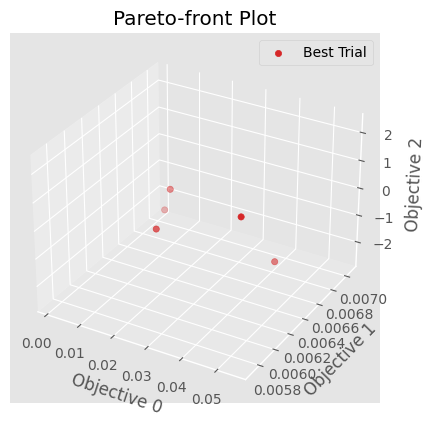

In [317]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [318]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

nan 0.07620546318277598
nan 0.14261950869390758
-7.243727316186804 10.040603538739036
-11.117307527996223 1.1093035808277958
nan 0.6794480825510846


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_40708/2890865355.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(vals).sum(), t.user_attrs['ws'])


[0.001105658956279055, 0.007045429495937562, -2.574322123547502]


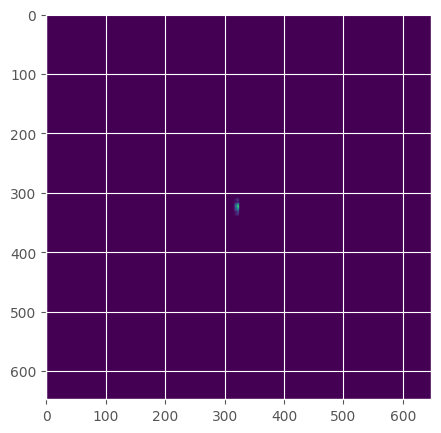

[0.04426440403227609, 0.006633953737674453, -1.9475749732490295]


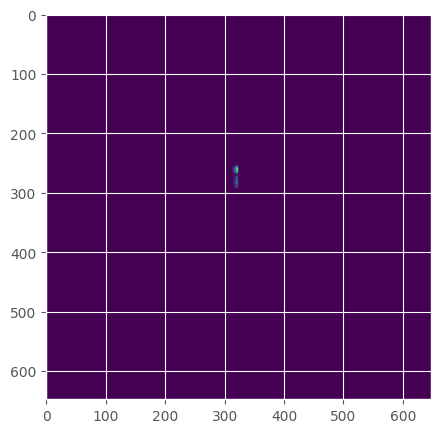

[0.054163900241143814, 0.00572005193513359, 2.3066372258770667]


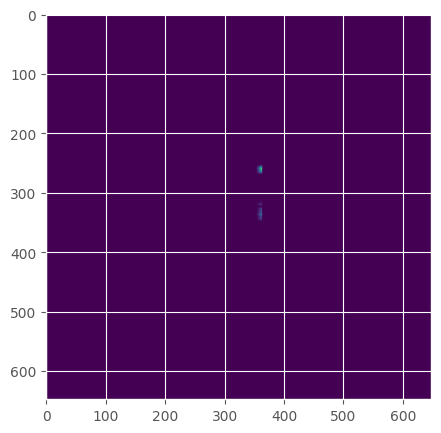

[0.023857762070493352, 0.006001647722969616, 0.10373241376393395]


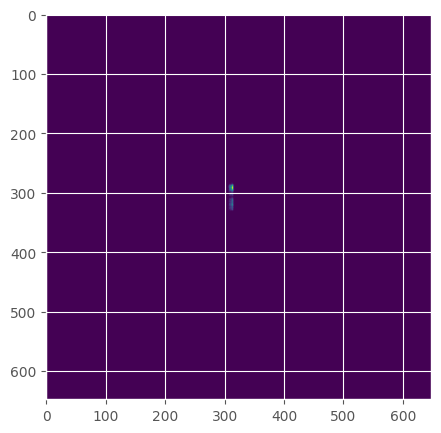

[0.012848515538365145, 0.006633953737674453, -0.38647445367997824]


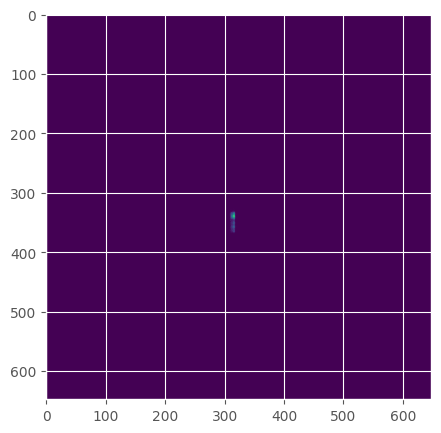

In [319]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    # for mot in opt_trial.motor_types:
    #    current_params.append(params[mot])
    # opt_trial._loss_fn_this(current_params)
    # print(t.values)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    print(vals)
    plt.figure(figsize=[5, 5])
    plt.imshow(t.user_attrs["data_2D"][700:-700,700:-700])
    #plt.axis("off")
    plt.show()

In [320]:
n2 = 50#opt_params.params["n_all_motor_trials"]
print(f"Optimizing all motors together for {n2} trials.")
opt_trial.trials(n2)

Optimizing all motors together for 50 trials.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:02:16,948] Trial 25 finished with values: [0.034375739308123154, 0.04801578659492199, 0.6620039895891453] and parameters: {'hb_1': -5.0, 'hb_2': -9.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': 0.003700000000000002, 'vb_bender': -5.0, 'vb_pitch': -5.999999999999994e-05, 'vb_trans': 0.009400000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:02:20,403] Trial 26 finished with values: [0.023738431843751892, 0.013126363774246001, -3.0337017234832393] and parameters: {'hb_1': -7.0, 'hb_2': 9.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.007000000000000006, 'vb_bender': 1.0, 'vb_pitch': -3.999999999999967e-05, 'vb_trans': -0.000899999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:02:25,158] Trial 27 finished with values: [0.0026576902187593426, 0.009902343750000054, -3.0758759964119506] and parameters: {'hb_1': -1.0, 'hb_2': 3.0, 'hb_pitch': 0.0, 'hb_trans': 0.0022000000000000006, 'vb_bender': 0.0, 'vb_pitch': -3.999999999999967e-05, 'vb_trans': -0.0006999999999999958}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:02:29,614] Trial 28 finished with values: [0.04195731638282413, 0.00638032608442578, 2.9857537858453838] and parameters: {'hb_1': 13.0, 'hb_2': -2.0, 'hb_pitch': 0.0, 'hb_trans': 0.0143, 'vb_bender': -2.0, 'vb_pitch': -0.0005199999999999998, 'vb_trans': 0.00020000000000000226}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:02:32,927] Trial 29 finished with values: [0.002864333725660375, 0.04045542550498386, 0.21873709671346714] and parameters: {'hb_1': 2.0, 'hb_2': 5.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.021200000000000004, 'vb_bender': -7.0, 'vb_pitch': -7.999999999999978e-05, 'vb_trans': -0.0139}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:02:37,195] Trial 30 finished with values: [0.036947994400228015, 0.0048671251908381265, -1.828367642009199] and parameters: {'hb_1': 10.0, 'hb_2': 7.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': 0.019200000000000002, 'vb_bender': 2.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': -0.0286}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:02:46,293] Trial 31 finished with values: [0.00367228235460665, 0.006001647722969616, -2.0789501145670486] and parameters: {'hb_1': 5.0, 'hb_2': 1.0, 'hb_pitch': 0.0, 'hb_trans': 0.0033000000000000043, 'vb_bender': 1.0, 'vb_pitch': -5.999999999999994e-05, 'vb_trans': -0.000499999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:02:52,108] Trial 32 finished with values: [0.053751336946050485, 0.08228167281746641, 0.8675769087597198] and parameters: {'hb_1': 3.0, 'hb_2': -10.0, 'hb_pitch': 0.0, 'hb_trans': 0.029000000000000005, 'vb_bender': 2.0, 'vb_pitch': 0.00010000000000000026, 'vb_trans': -0.003999999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:02:56,033] Trial 33 finished with values: [0.1135169049121928, 0.01744409853328389, 0.5163333496660654] and parameters: {'hb_1': 2.0, 'hb_2': 5.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': 0.002800000000000004, 'vb_bender': 7.0, 'vb_pitch': -9.999999999999983e-05, 'vb_trans': -0.0168}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:03:00,288] Trial 34 finished with values: [0.022922043272517574, 0.009174978845556547, 0.7827751390882485] and parameters: {'hb_1': 17.0, 'hb_2': 16.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.017800000000000003, 'vb_bender': -9.0, 'vb_pitch': -3.999999999999967e-05, 'vb_trans': 0.010500000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:03:04,296] Trial 35 finished with values: [0.015639311103624716, 0.04596743882499222, 2.5370624389954375] and parameters: {'hb_1': 4.0, 'hb_2': 21.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': 0.009900000000000006, 'vb_bender': -19.0, 'vb_pitch': 0.00018000000000000004, 'vb_trans': -0.0139}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:03:08,574] Trial 36 finished with values: [0.017292231983304415, 0.045156560919196176, -0.13358407901273228] and parameters: {'hb_1': -5.0, 'hb_2': 20.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.014600000000000002, 'vb_bender': -10.0, 'vb_pitch': 0.0002000000000000001, 'vb_trans': 0.019700000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:03:13,585] Trial 37 finished with values: [0.014721138632781397, 0.011751251965642535, 1.6238878413544726] and parameters: {'hb_1': -8.0, 'hb_2': -3.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': -0.0001999999999999988, 'vb_bender': -10.0, 'vb_pitch': 0.00018000000000000004, 'vb_trans': -0.0024999999999999988}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:03:19,663] Trial 38 finished with values: [0.036237823874903693, 0.011562523754199293, 1.6131224078054451] and parameters: {'hb_1': 16.0, 'hb_2': -2.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': 0.016300000000000002, 'vb_bender': -12.0, 'vb_pitch': -0.0002999999999999999, 'vb_trans': -0.004699999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:03:24,681] Trial 39 finished with values: [0.042490619218784796, 0.07063002395990242, -1.5034421015621409] and parameters: {'hb_1': 19.0, 'hb_2': 5.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': -0.006899999999999996, 'vb_bender': -1.0, 'vb_pitch': -0.00035999999999999986, 'vb_trans': -0.024}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:03:29,278] Trial 40 finished with values: [0.02308953482392647, 0.06444652818986851, 0.8241254089624971] and parameters: {'hb_1': -16.0, 'hb_2': 8.0, 'hb_pitch': 0.0, 'hb_trans': 0.029800000000000007, 'vb_bender': -5.0, 'vb_pitch': -0.0002999999999999999, 'vb_trans': -0.009899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:03:34,097] Trial 41 finished with values: [0.02281522854725838, 0.05258429700610849, 2.750819699265719] and parameters: {'hb_1': 6.0, 'hb_2': 11.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': 0.0063, 'vb_bender': -20.0, 'vb_pitch': 0.00047999999999999996, 'vb_trans': 0.009800000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:03:38,524] Trial 42 finished with values: [0.013423604656142684, 0.01460137557251438, -2.969865688908406] and parameters: {'hb_1': 3.0, 'hb_2': 7.0, 'hb_pitch': 0.0, 'hb_trans': 0.007400000000000004, 'vb_bender': -1.0, 'vb_pitch': -2.0000000000000052e-05, 'vb_trans': 0.00030000000000000165}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:03:43,144] Trial 43 finished with values: [0.022372674426904583, 0.03294634902477807, -1.6813912555451456] and parameters: {'hb_1': 10.0, 'hb_2': 0.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': 0.027100000000000006, 'vb_bender': 0.0, 'vb_pitch': 0.00012000000000000031, 'vb_trans': 0.008200000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:03:47,648] Trial 44 finished with values: [0.012420512689706455, 0.04494442576809505, 1.0603249466541007] and parameters: {'hb_1': -9.0, 'hb_2': 10.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': 0.013700000000000004, 'vb_bender': -19.0, 'vb_pitch': -3.999999999999967e-05, 'vb_trans': -0.0016999999999999967}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:03:53,554] Trial 45 finished with values: [0.023738431843751892, 0.07613473215516099, 0.4012735444489889] and parameters: {'hb_1': 25.0, 'hb_2': 22.0, 'hb_pitch': 0.0, 'hb_trans': 0.016300000000000002, 'vb_bender': -7.0, 'vb_pitch': 0.00030000000000000035, 'vb_trans': 0.017800000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:03:59,032] Trial 46 finished with values: [0.0030239637444255127, 0.007275909429908254, -2.544201684618516] and parameters: {'hb_1': -1.0, 'hb_2': 1.0, 'hb_pitch': 0.0, 'hb_trans': 0.004200000000000002, 'vb_bender': -1.0, 'vb_pitch': -3.999999999999967e-05, 'vb_trans': 0.00010000000000000286}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:04:03,647] Trial 47 pruned. 


Pruning trial with parameters [-12.0, -18.0, -0.0019, -0.021199999999999997, 7.0, -0.0005, 0.026600000000000006]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:04:08,612] Trial 48 finished with values: [0.06497216477440715, 0.0629116412684185, 1.6469590677573405] and parameters: {'hb_1': -16.0, 'hb_2': 10.0, 'hb_pitch': 0.0, 'hb_trans': 0.028200000000000003, 'vb_bender': 11.0, 'vb_pitch': -3.999999999999967e-05, 'vb_trans': 0.017}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:04:13,429] Trial 49 finished with values: [0.03303793791279723, 0.056589386441601476, 1.6344897437700499] and parameters: {'hb_1': 25.0, 'hb_2': 15.0, 'hb_pitch': 0.0, 'hb_trans': 0.0187, 'vb_bender': -11.0, 'vb_pitch': -0.0003799999999999999, 'vb_trans': -0.010899999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:04:17,656] Trial 50 finished with values: [0.042035375966913265, 0.0534788287332534, 1.2321186706827558] and parameters: {'hb_1': 9.0, 'hb_2': 5.0, 'hb_pitch': 0.0, 'hb_trans': -0.011399999999999997, 'vb_bender': -6.0, 'vb_pitch': -0.00011999999999999988, 'vb_trans': -0.026099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:04:23,261] Trial 51 finished with values: [0.004786132812499967, 0.034667530366950715, 1.0132975773368775] and parameters: {'hb_1': 8.0, 'hb_2': 10.0, 'hb_pitch': 0.0, 'hb_trans': 0.011100000000000006, 'vb_bender': 16.0, 'vb_pitch': -2.0000000000000052e-05, 'vb_trans': -0.007499999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:04:28,101] Trial 52 finished with values: [0.03130749777852589, 0.04769600352693775, 1.4722707052377624] and parameters: {'hb_1': 13.0, 'hb_2': 16.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': 0.029400000000000003, 'vb_bender': -18.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': 0.0031000000000000055}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:04:38,073] Trial 53 finished with values: [0.05389051295462637, 0.017311137452198685, 0.2429566347636855] and parameters: {'hb_1': -12.0, 'hb_2': 21.0, 'hb_pitch': 0.0005, 'hb_trans': -0.002199999999999997, 'vb_bender': 7.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': -0.005299999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:04:42,801] Trial 54 finished with values: [0.020928564391095424, 0.019617885296138338, 0.6243528748499714] and parameters: {'hb_1': -22.0, 'hb_2': 8.0, 'hb_pitch': 0.0, 'hb_trans': -0.0162, 'vb_bender': -10.0, 'vb_pitch': -3.999999999999967e-05, 'vb_trans': 0.008900000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:04:47,516] Trial 55 finished with values: [0.009327323073992037, 0.07081304656691009, 1.7453774797382722] and parameters: {'hb_1': -24.0, 'hb_2': 21.0, 'hb_pitch': 0.0, 'hb_trans': -0.0063999999999999994, 'vb_bender': -20.0, 'vb_pitch': 0.00030000000000000035, 'vb_trans': 0.013000000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:04:52,154] Trial 56 finished with values: [0.07053228740748936, 0.004422635825116302, 0.7043974734645174] and parameters: {'hb_1': -8.0, 'hb_2': 13.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': -0.021199999999999997, 'vb_bender': -6.0, 'vb_pitch': 0.0003600000000000001, 'vb_trans': 0.019600000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:04:57,080] Trial 57 finished with values: [0.019065810844692298, 0.053571330638977524, -0.3245437546549705] and parameters: {'hb_1': 20.0, 'hb_2': 17.0, 'hb_pitch': 0.0, 'hb_trans': 0.019300000000000005, 'vb_bender': 8.0, 'vb_pitch': -3.999999999999967e-05, 'vb_trans': -0.005499999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:05:01,788] Trial 58 finished with values: [0.019121420755989833, 0.015277731273850084, 1.6611872204076201] and parameters: {'hb_1': 9.0, 'hb_2': 10.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.017800000000000003, 'vb_bender': -1.0, 'vb_pitch': 0.00031999999999999997, 'vb_trans': 0.007100000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:05:06,515] Trial 59 finished with values: [0.018811938736866304, 0.037713831317732045, 0.6042119159859726] and parameters: {'hb_1': 17.0, 'hb_2': 11.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': 0.026000000000000002, 'vb_bender': 5.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': 0.001800000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:05:11,198] Trial 60 finished with values: [0.09788061320747667, 0.014861477900621933, 4.425974284726173] and parameters: {'hb_1': 8.0, 'hb_2': -18.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': 0.009900000000000006, 'vb_bender': 12.0, 'vb_pitch': -0.0007999999999999999, 'vb_trans': 0.020500000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:05:16,782] Trial 61 finished with values: [0.03270267405702543, 0.05972872945224022, 0.39188216708677254] and parameters: {'hb_1': -16.0, 'hb_2': 14.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': -0.008799999999999999, 'vb_bender': 14.0, 'vb_pitch': -0.00035999999999999986, 'vb_trans': -0.029099999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:05:22,019] Trial 62 finished with values: [0.1425408888428285, 0.025514849434332295, 5.434739712183593] and parameters: {'hb_1': 6.0, 'hb_2': -13.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': 0.006100000000000001, 'vb_bender': 15.0, 'vb_pitch': 0.0013800000000000002, 'vb_trans': -0.0278}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:05:26,769] Trial 63 finished with values: [0.22645831430804178, 0.0466322313688894, 4.862837359742828] and parameters: {'hb_1': -4.0, 'hb_2': 19.0, 'hb_pitch': 0.0015, 'hb_trans': -0.015299999999999998, 'vb_bender': -18.0, 'vb_pitch': -0.00112, 'vb_trans': 0.020000000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:05:32,365] Trial 64 finished with values: [0.0033202793254316753, 0.00638032608442578, -2.062101678459705] and parameters: {'hb_1': 7.0, 'hb_2': 4.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.013500000000000005, 'vb_bender': 3.0, 'vb_pitch': -0.00031999999999999997, 'vb_trans': -0.024}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:05:37,157] Trial 65 finished with values: [0.0574862716954995, 0.04958768261125165, 0.9703315122588332] and parameters: {'hb_1': -6.0, 'hb_2': 9.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.024600000000000004, 'vb_bender': -14.0, 'vb_pitch': 0.00030000000000000035, 'vb_trans': 0.018600000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:05:42,563] Trial 66 finished with values: [0.0030239637444255127, 0.013806897990819878, -2.11485148381785] and parameters: {'hb_1': -7.0, 'hb_2': 2.0, 'hb_pitch': 0.0, 'hb_trans': -0.003999999999999997, 'vb_bender': -3.0, 'vb_pitch': -3.999999999999967e-05, 'vb_trans': -0.0007999999999999986}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:05:47,407] Trial 67 finished with values: [0.028464037257024868, 0.03247580046926301, 1.636144536565418] and parameters: {'hb_1': -3.0, 'hb_2': 5.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': 0.016800000000000002, 'vb_bender': 8.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': -0.006299999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:05:52,295] Trial 68 finished with values: [0.02300671207924603, 0.006633953737674453, 0.6330379707458997] and parameters: {'hb_1': 14.0, 'hb_2': 1.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': 0.024100000000000003, 'vb_bender': 0.0, 'vb_pitch': -0.00021999999999999993, 'vb_trans': -0.0295}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:05:59,345] Trial 69 finished with values: [0.0005315380437518685, 0.007045429495937562, -2.5336730126224007] and parameters: {'hb_1': 2.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.004200000000000002, 'vb_bender': 0.0, 'vb_pitch': -3.999999999999967e-05, 'vb_trans': -0.0033999999999999968}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:06:04,514] Trial 70 finished with values: [0.010066037948082066, 0.014212967923127293, 1.0734208054479928] and parameters: {'hb_1': 4.0, 'hb_2': 13.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': 0.021500000000000005, 'vb_bender': 9.0, 'vb_pitch': -0.00011999999999999988, 'vb_trans': -0.0218}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:06:10,289] Trial 71 finished with values: [0.24156807722436355, 0.14274182126854906, 5.319351441070322] and parameters: {'hb_1': -21.0, 'hb_2': -20.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.027800000000000005, 'vb_bender': 9.0, 'vb_pitch': -0.00162, 'vb_trans': -9.999999999999593e-05}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:06:15,612] Trial 72 finished with values: [0.01259580386241748, 0.02091646646755934, -0.24342456493076517] and parameters: {'hb_1': -2.0, 'hb_2': 10.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.009000000000000001, 'vb_bender': 9.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': -0.0225}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:06:20,903] Trial 73 finished with values: [0.0545086292907133, 0.011918890543261602, 3.927021614551556] and parameters: {'hb_1': 13.0, 'hb_2': 22.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': 0.028000000000000004, 'vb_bender': 12.0, 'vb_pitch': 0.0005800000000000002, 'vb_trans': -0.015499999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 09:06:26,024] Trial 74 finished with values: [0.013738281562377776, 0.0178981395415236, -0.17812858232004364] and parameters: {'hb_1': -2.0, 'hb_2': 7.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.0007000000000000027, 'vb_bender': -3.0, 'vb_pitch': 0.0002400000000000002, 'vb_trans': 0.014000000000000005}. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_40708/384703890.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes3DSubplot:title={'center':'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

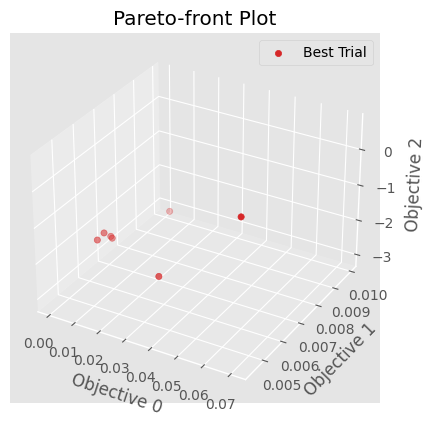

In [321]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [322]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

nan 0.07620546318277598
nan 0.046149184150035626
nan 0.16067563397910287
nan 0.12506144348535916
-8.423116605858576 2.022627630884017
nan 0.12718638392002365
nan 0.0793669683824036


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_40708/2890865355.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(vals).sum(), t.user_attrs['ws'])


[0.001105658956279055, 0.007045429495937562, -2.574322123547502]
{'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}


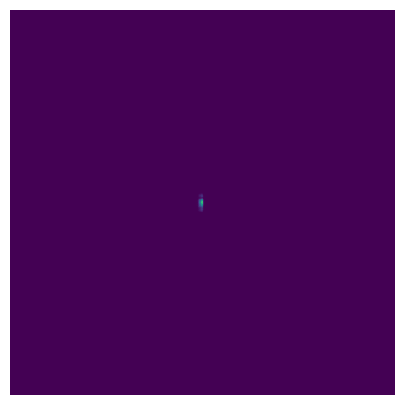

[0.0026576902187593426, 0.009902343750000054, -3.0758759964119506]
{'hb_1': -1.0, 'hb_2': 3.0, 'hb_pitch': 0.0, 'hb_trans': 0.0022000000000000006, 'vb_bender': 0.0, 'vb_pitch': -3.999999999999967e-05, 'vb_trans': -0.0006999999999999958}


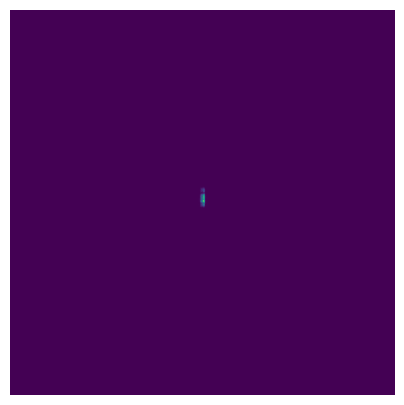

[0.036947994400228015, 0.0048671251908381265, -1.828367642009199]
{'hb_1': 10.0, 'hb_2': 7.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': 0.019200000000000002, 'vb_bender': 2.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': -0.0286}


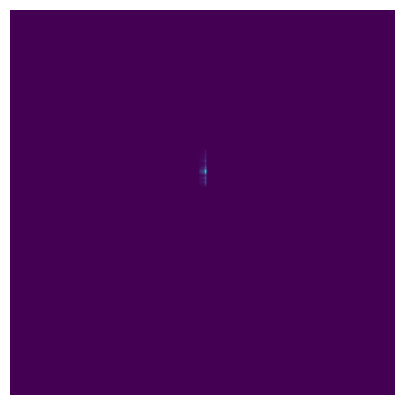

[0.00367228235460665, 0.006001647722969616, -2.0789501145670486]
{'hb_1': 5.0, 'hb_2': 1.0, 'hb_pitch': 0.0, 'hb_trans': 0.0033000000000000043, 'vb_bender': 1.0, 'vb_pitch': -5.999999999999994e-05, 'vb_trans': -0.000499999999999997}


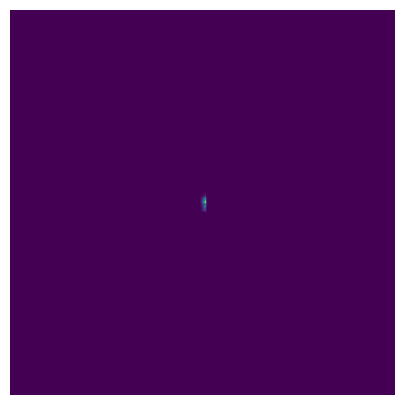

[0.07053228740748936, 0.004422635825116302, 0.7043974734645174]
{'hb_1': -8.0, 'hb_2': 13.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': -0.021199999999999997, 'vb_bender': -6.0, 'vb_pitch': 0.0003600000000000001, 'vb_trans': 0.019600000000000006}


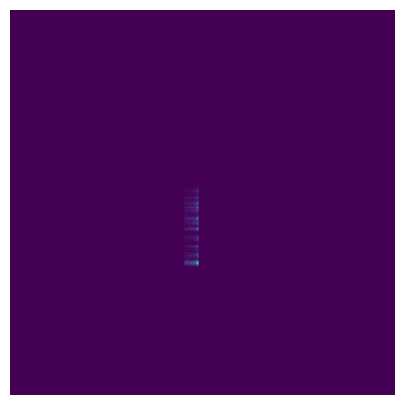

[0.0033202793254316753, 0.00638032608442578, -2.062101678459705]
{'hb_1': 7.0, 'hb_2': 4.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.013500000000000005, 'vb_bender': 3.0, 'vb_pitch': -0.00031999999999999997, 'vb_trans': -0.024}


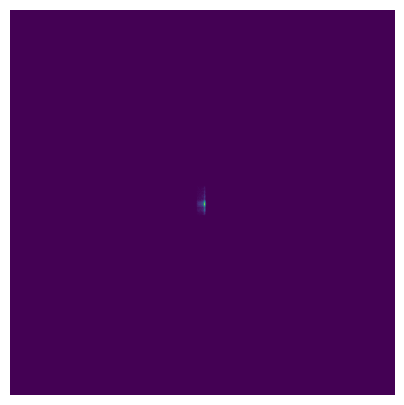

[0.0005315380437518685, 0.007045429495937562, -2.5336730126224007]
{'hb_1': 2.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.004200000000000002, 'vb_bender': 0.0, 'vb_pitch': -3.999999999999967e-05, 'vb_trans': -0.0033999999999999968}


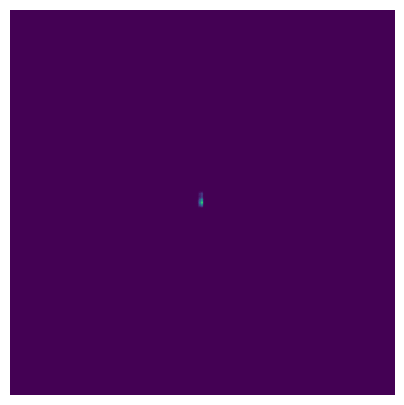

In [327]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    # for mot in opt_trial.motor_types:
    #    current_params.append(params[mot])
    # opt_trial._loss_fn_this(current_params)
    # print(t.values)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    print(vals)
    print(params)
    plt.figure(figsize=[5, 5])
    plt.imshow(t.user_attrs["data_2D"][700:-700,700:-700])
    plt.axis("off")
    plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_40708/1554866980.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(opt_trial.study, target=lambda t: t.values[0])
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/visualization/_utils.py:69: UserWarning: `target` is specified, but `target_name` is the default value, 'Objective Value'.
  warnings.warn(


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

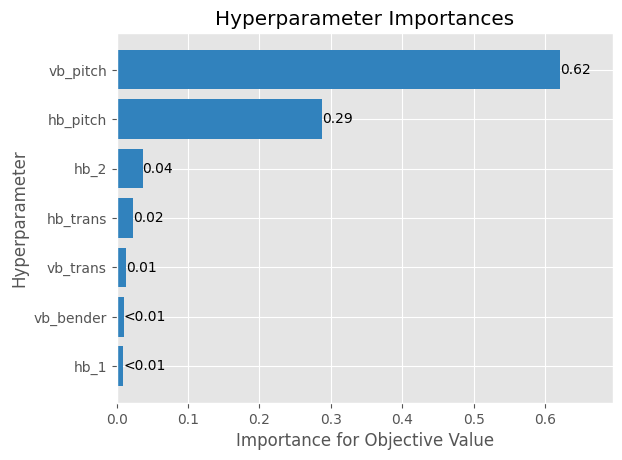

In [329]:
optuna.visualization.matplotlib.plot_param_importances(opt_trial.study, target=lambda t: t.values[0])

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_40708/3253766292.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(opt_trial.study, target=lambda t: t.values[1])
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/visualization/_utils.py:69: UserWarning: `target` is specified, but `target_name` is the default value, 'Objective Value'.
  warnings.warn(


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

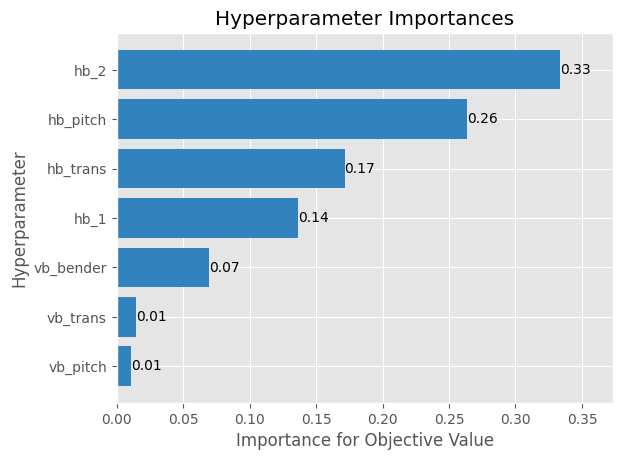

In [330]:
optuna.visualization.matplotlib.plot_param_importances(opt_trial.study, target=lambda t: t.values[1])

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_40708/297042928.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(opt_trial.study, target=lambda t: t.values[2])
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/visualization/_utils.py:69: UserWarning: `target` is specified, but `target_name` is the default value, 'Objective Value'.
  warnings.warn(


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

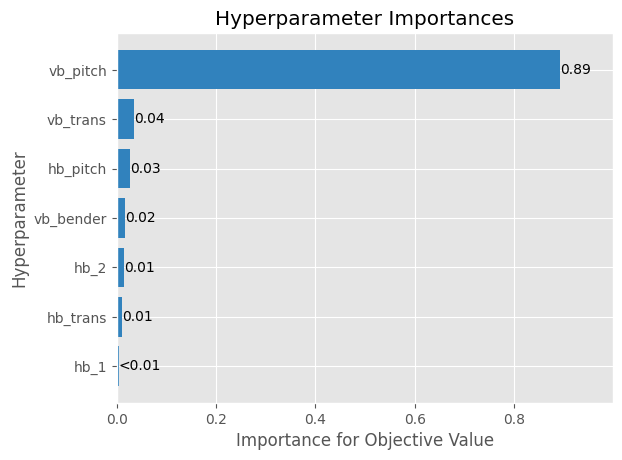

In [331]:
optuna.visualization.matplotlib.plot_param_importances(opt_trial.study, target=lambda t: t.values[2])